TTC Delay Predictor (Team 14) Project Source Code
Goal: Develop a machine learning regression model to predict the average subway delay (in minutes) using historical TTC subway delay data.
Scope: Analyze factors such as time of day, station location, and train line to uncover trends and improve predictions.
Source of Data: https://open.toronto.ca/dataset/ttc-subway-delay-data/

In [1]:
# Importing Necessary Libraries
# # Data Handling Libraries
import pandas as pd
import numpy as np
import os
import glob
# Data Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
# Feature Engineering Libraries
from datetime import datetime
# Machine Learning Models Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
# Model Evaluation Libraries
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

Part 1) Data Collection, Cleaning and Exploration (by Faraz Shahid)

In [2]:
# Data Acquisition

# GitHub Raw File URL (Updated)
url = "https://raw.githubusercontent.com/ceejay868/Team-14/main/data/combined/ttc-subway-delay-data.csv"

# Load dataset with CSV UTF-8 encoding
try:
    df = pd.read_csv(url, encoding="utf-8")
    print(f"Successfully Loaded Dataset from GitHub!")
    print(f"Dataset Shape: {df.shape}")
    print("\nFirst 5 Rows:")
    print(df.head())
except Exception as e:
    print(f"Failed to Load Dataset: {e}")

Successfully Loaded Dataset from GitHub!
Dataset Shape: (211913, 10)

First 5 Rows:
         Date  Time        Day                Station   Code  Min Delay  \
0  2014-01-01  0:21  Wednesday  VICTORIA PARK STATION  MUPR1       55.0   
1  2014-01-01  2:06  Wednesday      HIGH PARK STATION   SUDP        3.0   
2  2014-01-01  2:40  Wednesday       SHEPPARD STATION  MUNCA        0.0   
3  2014-01-01  3:10  Wednesday      LANSDOWNE STATION   SUDP        3.0   
4  2014-01-01  3:20  Wednesday          BLOOR STATION  MUSAN        5.0   

   Min Gap Bound Line  Vehicle  
0     60.0     W   BD   5111.0  
1      7.0     W   BD   5001.0  
2      0.0   NaN   YU      0.0  
3      8.0     W   BD   5116.0  
4     10.0     S   YU   5386.0  


C:\Users\ifara\AppData\Local\Temp\ipykernel_3816\2122594716.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  na_values = (df.applymap(lambda x: str(x).strip().lower() == 'n/a')).sum()  # 'n/a' strings


Missing values detected as follows:

Min Delay     1296
Min Gap       1341
Bound        56129
Line           678
Vehicle        817


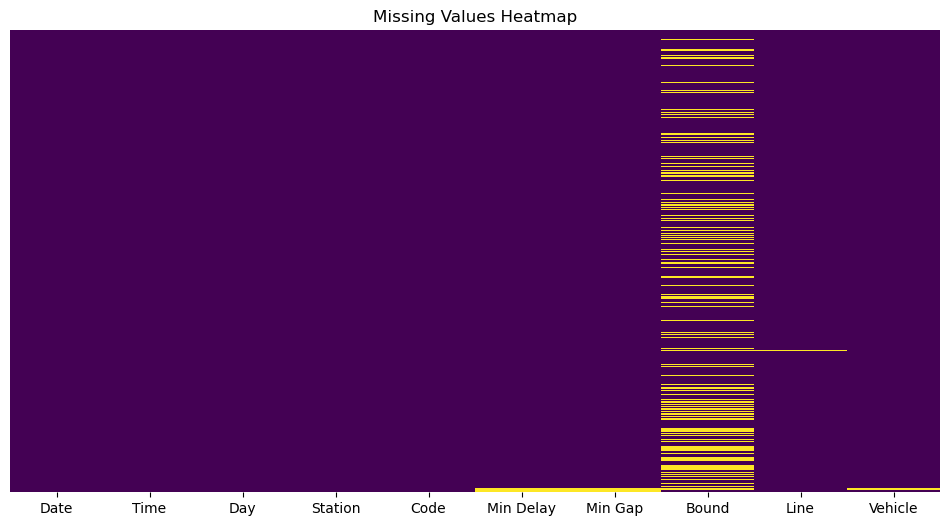

In [3]:
# Check for Missing Values

# Checking for missing values: null, empty cells, and 'n/a' strings
missing_values = df.isnull().sum()  # Standard missing values (NaN)
empty_values = (df == "").sum()  # Empty strings
na_values = (df.applymap(lambda x: str(x).strip().lower() == 'n/a')).sum()  # 'n/a' strings

# Combining all missing value checks
total_missing = missing_values + empty_values + na_values

# Displaying only columns with missing data
total_missing = total_missing[total_missing > 0]

# Printing results in a clean format
if total_missing.empty:
    print("No missing values found in the dataset!")
else:
    print("Missing values detected as follows:\n")
    print(total_missing.to_string())

# Visualizing missing values using a heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cmap="viridis", cbar=False, yticklabels=False)
plt.title("Missing Values Heatmap")
plt.show()

In [4]:
# Handling Missing Values

def impute_station_mean(df, column):
    return df[column].replace([0, "", "N/A", "NaN", None], pd.NA).fillna(df.groupby("Station")[column].transform("mean"))

def impute_most_frequent(df, column):
    return df[column].replace(["", "N/A", "NaN", None], pd.NA).fillna(df.groupby("Station")[column].transform(lambda x: x.mode()[0] if not x.mode().empty else "Unknown"))

# Replacing missing values in "Min Delay" and "Min Gap" with station-specific mean
df["Min Delay"] = impute_station_mean(df, "Min Delay")
df["Min Gap"] = impute_station_mean(df, "Min Gap")

# Dropping rows where "Station" is missing
df = df.dropna(subset=["Station"])

# Dropping rows where "Date", "Time", or "Day" is missing
df = df.dropna(subset=["Date", "Time", "Day"])

# Replacing missing values in "Code" with the most common "Code" for the corresponding "Station"
df["Code"] = impute_most_frequent(df, "Code")

# Replacing missing values in "Bound" with the most frequent "Bound" for the corresponding "Station"
df["Bound"] = impute_most_frequent(df, "Bound")

# Replacing missing values in "Line" with the most frequent "Line" for the corresponding "Station"
df["Line"] = impute_most_frequent(df, "Line")

# Drop rows where "Vehicle" is missing
df = df.dropna(subset=["Vehicle"])

# Displaying dataset shape after handling missing values
print(f"Updated dataset shape after handling missing values: {df.shape}")

# Displaying the first few rows of the cleaned dataset
df.head()


C:\Users\ifara\AppData\Local\Temp\ipykernel_3816\2885340897.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return df[column].replace([0, "", "N/A", "NaN", None], pd.NA).fillna(df.groupby("Station")[column].transform("mean"))
C:\Users\ifara\AppData\Local\Temp\ipykernel_3816\2885340897.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return df[column].replace([0, "", "N/A", "NaN", None], pd.NA).fillna(df.groupby("Station")[column].transform("mean"))


Updated dataset shape after handling missing values: (211096, 10)


,Date,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle
0,2014-01-01,0:21,Wednesday,VICTORIA PARK STATION,MUPR1,55.000000,60.000000,W,BD,5111.0
1,2014-01-01,2:06,Wednesday,HIGH PARK STATION,SUDP,3.000000,7.000000,W,BD,5001.0
2,2014-01-01,2:40,Wednesday,SHEPPARD STATION,MUNCA,2.513655,3.747849,N,YU,0.0
3,2014-01-01,3:10,Wednesday,LANSDOWNE STATION,SUDP,3.000000,8.000000,W,BD,5116.0
4,2014-01-01,3:20,Wednesday,BLOOR STATION,MUSAN,5.000000,10.000000,S,YU,5386.0


C:\Users\ifara\AppData\Local\Temp\ipykernel_3816\3538717857.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  na_values = (df.applymap(lambda x: str(x).strip().lower() == 'n/a')).sum()  # 'n/a' strings


No missing values found in the dataset after cleaning


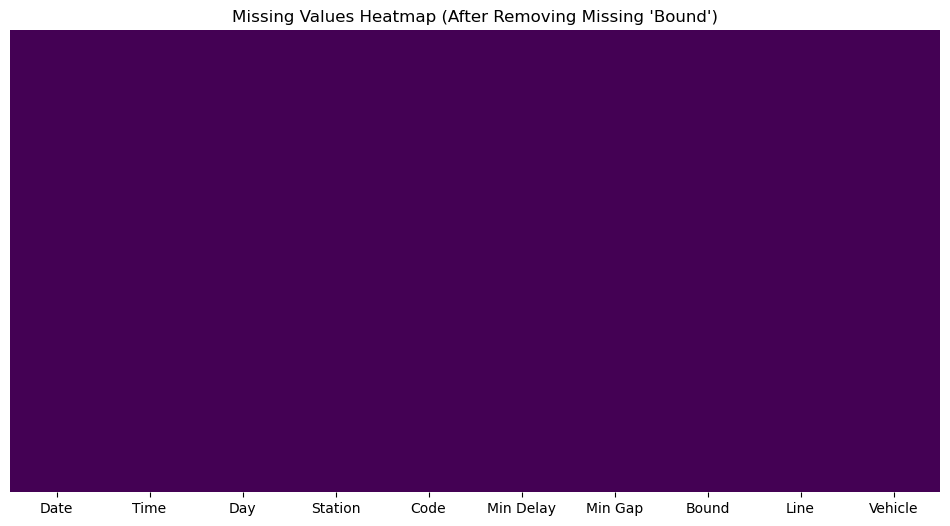

In [5]:
# Re-Check for Missing Values

# Checking for missing values: null, empty cells, and 'n/a' strings
missing_values = df.isnull().sum()  # Standard missing values (NaN)
empty_values = (df == "").sum()  # Empty strings
na_values = (df.applymap(lambda x: str(x).strip().lower() == 'n/a')).sum()  # 'n/a' strings

# Combining all missing value checks
total_missing = missing_values + empty_values + na_values

# Displaying only columns with missing data
total_missing = total_missing[total_missing > 0]

# Printing results
if total_missing.empty:
    print("No missing values found in the dataset after cleaning")
else:
    print("Missing values detected after cleaning:\n")
    print(total_missing.to_string())

# Visualizing missing values using a heatmap after cleaning
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cmap="viridis", cbar=False, yticklabels=False)
plt.title("Missing Values Heatmap (After Removing Missing 'Bound')")
plt.show()


In [6]:
# Check for duplicate rows in the dataset
duplicate_rows = df.duplicated().sum()

# Print the number of duplicate rows
print(f"Total duplicate rows in the dataset: {duplicate_rows}")


Total duplicate rows in the dataset: 196


In [7]:
# Removing duplicate rows from the dataset
df = df.drop_duplicates()

# Printing the updated dataset shape after removing duplicates
print(f"Dataset shape after removing duplicates: {df.shape}")

df.head()

Dataset shape after removing duplicates: (210900, 10)


,Date,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle
0,2014-01-01,0:21,Wednesday,VICTORIA PARK STATION,MUPR1,55.000000,60.000000,W,BD,5111.0
1,2014-01-01,2:06,Wednesday,HIGH PARK STATION,SUDP,3.000000,7.000000,W,BD,5001.0
2,2014-01-01,2:40,Wednesday,SHEPPARD STATION,MUNCA,2.513655,3.747849,N,YU,0.0
3,2014-01-01,3:10,Wednesday,LANSDOWNE STATION,SUDP,3.000000,8.000000,W,BD,5116.0
4,2014-01-01,3:20,Wednesday,BLOOR STATION,MUSAN,5.000000,10.000000,S,YU,5386.0


In [8]:
# Re-Checking for duplicate rows
duplicate_rows = df.duplicated().sum()

# Print the number of duplicate rows
print(f"Total duplicate rows in the dataset: {duplicate_rows}")

Total duplicate rows in the dataset: 0


In [9]:
# Ensure Correct Data Types

# Converting "Date" column to datetime format
df["Date"] = pd.to_datetime(df["Date"], format="%Y-%m-%d", errors="coerce")

# Converting "Time" column to proper time format
df["Time"] = pd.to_datetime(df["Time"], format="%H:%M", errors="coerce").dt.time

# Ensuring "Day" is a string and has valid values
df["Day"] = df["Day"].astype(str).str.strip()

# Ensuring categorical columns are strings
categorical_columns = ["Station", "Code", "Bound", "Line", "Vehicle"]
for col in categorical_columns:
    df[col] = df[col].astype(str).str.strip().str.lower()

# Ensuring "Min Delay" and "Min Gap" are numeric
df["Min Delay"] = pd.to_numeric(df["Min Delay"], errors="coerce")
df["Min Gap"] = pd.to_numeric(df["Min Gap"], errors="coerce")

# Display data types to confirm changes
print(df.dtypes)

Date         datetime64[ns]
Time                 object
Day                  object
Station              object
Code                 object
Min Delay           float64
Min Gap             float64
Bound                object
Line                 object
Vehicle              object
dtype: object


In [10]:
df.head() # double checking data frame

,Date,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle
0,2014-01-01,00:21:00,Wednesday,victoria park station,mupr1,55.000000,60.000000,w,bd,5111.0
1,2014-01-01,02:06:00,Wednesday,high park station,sudp,3.000000,7.000000,w,bd,5001.0
2,2014-01-01,02:40:00,Wednesday,sheppard station,munca,2.513655,3.747849,n,yu,0.0
3,2014-01-01,03:10:00,Wednesday,lansdowne station,sudp,3.000000,8.000000,w,bd,5116.0
4,2014-01-01,03:20:00,Wednesday,bloor station,musan,5.000000,10.000000,s,yu,5386.0


In [11]:
# Checking for Inconsistent Values

# unique values in categorical columns to check for inconsistencies
for col in ["Day", "Station", "Code", "Bound", "Line"]:
    print(f"Unique values in '{col}': {df[col].unique()}")


Unique values in 'Day': ['Wednesday' 'Thursday' 'Friday' 'Saturday' 'Sunday' 'Monday' 'Tuesday']
Unique values in 'Station': ['victoria park station' 'high park station' 'sheppard station' ...
 'finch station to st ge' 'union station- st andr'
 'davisville - st. clair']
Unique values in 'Code': ['mupr1' 'sudp' 'munca' 'musan' 'mupaa' 'munoa' 'tusc' 'sug' 'muto' 'musc'
 'sueas' 'muir' 'suo' 'mui' 'muplb' 'tumvs' 'putij' 'pumel' 'suut' 'suap'
 'eudo' 'erwa' 'euoe' 'tuos' 'mudd' 'tunoa' 'erdo' 'eupi' 'putis' 'tunip'
 'mugd' 'ertc' 'pumst' 'pusi' 'pusis' 'muo' 'euecd' 'tuml' 'eunt' 'mud'
 'eunea' 'euch' 'pusic' 'puttc' 'suae' 'mufm' 'puso' 'pusnt' 'tuo' 'erpr'
 'pucss' 'pustc' 'euo' 'tust' 'putdn' 'ertl' 'eume' 'mrto' 'pusts' 'eutrd'
 'muwea' 'sucol' 'mrwea' 'mrpaa' 'susa' 'subt' 'tusup' 'eubk' 'eusc'
 'supol' 'eulv' 'putwz' 'mro' 'tudoe' 'mutd' 'mrnoa' 'pumo' 'mrui' 'erco'
 'ernea' 'mruir' 'erlv' 'euca' 'tucc' 'muplc' 'pucsc' 'tus' 'euac' 'eucd'
 'eubo' 'mupla' 'eutr' 'pussw' 'erdb' 'euve

In [12]:
# Bounds 5, R, Y, B are invalid values per TTC so we will remove them

# Storing the original dataset size before removal
original_shape = df.shape

invalid_bounds = ["5", "r", "y", "b"] # invalid "Bound" values

# Removing rows where "Bound" contains invalid values
df_cleaned = df[~df["Bound"].isin(invalid_bounds)]

# Storing the new dataset size after removal
new_shape = df_cleaned.shape

# Printing dataset size before and after removal
print(f"Original dataset shape: {original_shape}")
print(f"Dataset shape after removing invalid 'Bound' values: {new_shape}")
print(f"Total rows removed: {original_shape[0] - new_shape[0]}")
df = df_cleaned # Updating the dataset

# Final Step: Removing rows where "Bound" is "Unknown"
df = df[~df["Bound"].astype(str).str.strip().str.lower().eq("unknown")]

Original dataset shape: (210900, 10)
Dataset shape after removing invalid 'Bound' values: (207813, 10)
Total rows removed: 3087


In [13]:
# The "Line" column has names that do not follow the standard of TTC and they need to be re-mapped as below:
#(i) 'yus'	need to be re-labelled to 'yu'
#(ii) 'line 1'	needs to be re-labelled to 'yu'
#(iii) 'bloor danforth'	needs to be re-labelled to 'bd'
#(iv) 'rt'	needs to be re-labelled to 'srt'

#Additionally, "Line" column with value of 'yu/bd' and 'yus & bd' is a combination of two subway lines and these rows should be removed

# Storing original dataset size before modifications
original_shape = df.shape

# Defining mapping for standardizing "Line" column
line_mapping = {
    "yus": "yu",
    "line 1": "yu",
    "bloor danforth": "bd",
    "rt": "srt"
}

# Applying the mapping to standardize line names
df["Line"] = df["Line"].replace(line_mapping)

# Removing rows where "Line" contains combined subway lines ('yu/bd' and 'yus & bd')
df_cleaned = df[~df["Line"].isin(["yu/bd", "yus & bd"])]

# Storing new dataset size after removal
new_shape = df_cleaned.shape

# Printing the number of rows removed
rows_removed = original_shape[0] - new_shape[0]
print(f"'Line' column is standardized per TTC.")
print(f"Removed rows where 'Line' contained combined subway lines ('yu/bd', 'yus & bd').")
print(f"Total rows removed: {rows_removed}")
print(f"Updated dataset shape: {new_shape}")


df = df_cleaned # Updating the dataset


'Line' column is standardized per TTC.
Removed rows where 'Line' contained combined subway lines ('yu/bd', 'yus & bd').
Total rows removed: 1034
Updated dataset shape: (204984, 10)


C:\Users\ifara\AppData\Local\Temp\ipykernel_3816\977124754.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Line"] = df["Line"].replace(line_mapping)


In [14]:
# Ensuring 'Station' column has correct labels
# There were a number of incorrect/unwanted values in the 'Station' column that need to be removed (not a subway station/bus station i.e., train yard)

# List of unwanted station values
unwanted_stations = [
    "mccowan station to ken", "bloor danforth subway", "sheppard line", "chester to broadview",
    "kennedy station to kip", "russell hill emergency", "finch to downsview", "eglinton to lawrence s",
    "eglinton west to bloor", "bloor to king stations", "chester to castlefrank", "lytton emergency exit",
    "bloor to york mills", "bloor to davisville", "danforth division", "finch to lawrence stat",
    "(approaching)", "moore gate", "eglinton to finch", "kipling station (enter", "union station (downsvi",
    "jane station (approach", "downsview station", "woodbine station (leav", "kennedy bd station (ap",
    "old mill station (exit", "old mill station (appr", "st george station", "dupont station (approa",
    "york mills station (ap", "islington station (app", "kennedy station (paltf", "high park station (ent",
    "wilson station (approa", "royal york station (ap", "kennedy", "mccowan station (appro",
    "kennedy srt station (a", "dupont station (leavin", "union station (st andr", "st george bd station -",
    "wellesley station (app", "woodbine station (appr", "kipling station (leavi", "downsview station plat",
    "royal york station (le", "st clair station (appr", "york mills station (le", "union station (to st a",
    "warden station (leavin", "keele station (approac", "donlands to kipling st", "kipling station (appro",
    "sheppard station (ente", "glencairn station (app", "keele station (exiting", "rosedale station (app",
    "kipling station (platf", "coxwell station (enter", "chester station (enter", "kennedy srt station [a",
    "royal york station (en", "christie station (appr", "kennedy bd station (en", "dundas west station (a",
    "eglinton station (appr", "jane station (entering", "lawrence station (leav", "st andrew station (lea",
    "donlands station (appr", "woodbine station (exit", "mccowan station (depar", "kennedy srt station (e",
    "finch station (approac", "srt line", "line 1 yus", "line 3 scarborough srt", "bloor-danforth line",
    "greenwood wye", "zone 1", "zone 2", "line 4", "migration point", "sheppard subway line",
    "yonge university spad", "eglinton migration", "main to victoria park", "line 3 - scarborough r",
    "viaduct", "transit control centre", "systemwide", "atc failure", "scarborough rapid tran",
    "system wide", "approaching", "sheppard west migration", "dupont migration point",
    "migration point eglint", "eglinton station migration", "tyssse line", "sheppard west to wilso",
    "union station (towards", "lawrence east to elles", "eglinton west to vmc", "midland approaching",
    "eglinton (migration)", "dupont station approac", "eglinton migration poi", "eglinton station (migr",
    "eglinton station migration", "migratio", "migration", "union station to finch", "wilson station to vmc", "e13",
    "sherbourne station (en", "sherbourne station (ap", "kennedy bd station (ex", "glenacairn station (ap",
    "ossington station (app", "islington station (ent", "finch station (exiting", "dupont station (exitin",
    "yonge station (exiting", "eglinton station (exit", "yorkdale station (exit", "finch station (leaving",
    "leaving kennedy statio", "coxwell station (leave", "entering leslie statio", "high park station (app",
    "islington station (lea", "yonge shp station (lea", "donlands station (ente", "jane station (exiting)",
    "coxwell station (exiti", "museum station (approa", "kennedy bd station (le", "keele station (enterin",
    "mccowan station (enter", "kennedy srt station (l", "museum station (leavin", "sheppard station (appr",
    "ellesmere station depa", "kipling station (exiti", "islington station (exi", "union station (approach",
    "rosedale station (appr", "christie station (leav", "union to king", "union station (enterin",
    "broadview to yonge sta", "warden station (appr", "dupont station ( appro", "chester station (leave",
    "leslie station approach", "islington station ( ap", "kennedy bd station ( a", "wilson station (exitin",
    "kipling station to ken", "tysse line", "sheppard west migrate", "union to st george",
    "warden to kennedy stat", "leaving lawrence east", "mccowan to kennedy sta", "dufferin to Lansdowne",
    "wilson to Eglinton", "king station to union", "leaving yonge/sheppard", "glencairn to st George",
    "st clair west to eglin", "st clair west to dupon", "old mill to Islington", "kipling to royal York",
    "king to union", "leslie station(approach", "union to st Andrew", "greenwood wye (enteri", "vmc to sheppard west",
    "union station to king", "union station to st an", "keele to dundas west",
    "welbeck emergency exit", "union to king station", "union (to st andrew)",
    "castle frank to sherbo", "lawrence to eglinton s", "finch to union station", "northbound to lawrence",
    "kipling to kennedy", "broadview to yonge", "st clair west to union", "mccowan parking lot",
    "sheppard west to downs", "yonge bd station (leav", "finch station to dupon", "union station (to king",
    "davisville to n/o bloo", "eglinton to bloor stat", "n/o davisville to n/o", "bloor via duct",
    "warden to victoria par", "wilson to st clair wes", "kipling to high park", "kipling to kennedy stn",
    "kipling to coxwell", "yorkdale to finch stat", "wilson to sheppard wes", "union to finch",
    "s/o eglinton to st cla", "queen's park to st cla", "kennedy to kipling sta", "kennedy to kipling",
    "union station to st cl", "wilson station to york", "ellis bridge", "broadview to kipling s",
    "victoria park to kenne", "union to finch station", "chester to warden", "islington to prince ed",
    "yonge to coxwell stati", "kipling to kennedy sta", "kipling to islington s", "church emergency exit",
    "w/o castle frank to gr", "chester to yonge stati", "mcbrien buiding", "bloor to st.clair",
    "vmc station to sheppar", "bloor to union", "wilson division traile", "finch to north york ct",
    "kennedy to lawrence ea", "finch to vaughan metro", "kennedy bd to kipling", "davisville to eglinton",
    "dupont to st clair wes", "museum to finch statio", "eastbound - between sh", "spadina to osgoode",
    "finch to queen station", "bloor to eglinton", "st clair to union stat", "yonge - sheppard (leav",
    "kennedy to mccowan", "coxwell to kennedy sta", "dufferin to kipling st", "keele station to kipli",
    "union station to st. a", "st clair station (leav", "leaving sheppard/yonge", "north hostler",
    "bloor viaduct", "lawrence station to yo", "royal york to islingto", "markdale ee", "leaving don mills",
    "eglinton to sheppard", "queen to finch station", "queen to king stations", "st george to bloor sta",
    "victoria park to warde", "yonge univesity and bl", "scarborough srt line",
    "york mills to lawrence", "n/o wilson to s/o shep", "bloor danforth line", "eglinton station (ente",
    "eglinton station (leav", "greenwood portal (exit", "bloor to college", "kennedy to mccowan - l",
    "summerhill to bloor st", "kipling to islington", "leslie station (leavin", "bayview to shepaprd/yo",
    "n/o queen to markdale", "jane station to old mi", "greenwood station (app", "finch to rosedale",
    "finch west to wilson", "warden to kennedy", "pioneer village to vau", "wilson to lawrence wes",
    "kipling station to jan", "eglinton station to va", "eglinton station appro", "vmc to eglinton statio",
    "old mill to royal york", "yus line", "bayview to bessarion", "kipling to jane", "york mills (approachin",
    "midland to scarborough", "kennedy srt station to", "museum to eglinton sta", "union station towards",
    "n/b towards finch", "vmc to lawrence", "union station(toward k", "king to college",
    "college to king", "yonge station to green", "line 1 bloor to queen", "union to sheppard west",
    "dupont station to spad", "greenwood wye departin", "south bound south of l", "finch to queens park s",
    "union station (toward", "st andrew station to o", "lawrence to york mills", "ossington station(appr",
    "king station to osgood", "approching old mill st", "bloor to davisville st", "broadview to chester s",
    "union (to finch)", "union station - toward", "union station from kin", "union to wilson",
    "sheppard - yonge (line", "woodbine station leavi", "union to st. andrew",
    "museum station to finc", "rosedale to bloor", "st george to queens pa", "union station - finch",
    "birchmount ee", "finch to eglinton stat", "union to st. andrew st", "union station toward k",
    "midland station to ell", "eglinton station to st", "bathurst to castle fra", "jane to ossington stat",
    "leaving pape", "st. clair station (app", "wellbeck ee", "clanton portal to egli",
    "north york ctr to finc", "st andrew station to u", "king to osgoode statio", "dundas station to egli",
    "ossington to pape", "lansdowne to royal yor", "st george to pape", "union to king stations",
    "union station--st andr", "dufferin to kipling", "bathust to pape statio", "christie to pape stati",
    "christie station to pa", "dundas to finch statio", "chrstie to pape statio",
    "bay station to pape st", "ossington to chester", "kipling station to cox", "leslie station (approa",
    "christie station to ch", "yonge station to chest", "royal york station(app", "islington to kipling",
    "kilping station to jan", "dupont station to egli", "leaving islington", "st clair to davisville",
    "broadview and st georg", "old mill station to ja", "leslie station (enteri", "kennedy to coxwell",
    "yonge bd station to co", "st george to broadview", "sheppard to york mills", "union station - nb to",
    "union to st andrew sta", "union station to st a", "union station ( toward", "dupont to spadina",
    "kipling to old mill", "main street staiton", "e/o warden to w/o vict", "finch to union",
    "(approaching) kennedy", "high park to keele sta", "approaching dundas wes", "coxwell to kennedy",
    "islington to old mill", "eglinton to lawrence", "donlands to greenwod y", "summerhill station to",
    "jane to old mill", "wilson station approac", "finch to st clair west", "eglinton to davisville",
    "davisville to lawrence", "eglinton to union stat", "spadina to wilson stat", "finch to museum",
    "greenwood to donlands", "high park to keele", "union station to vmc", "finch station to st ge",
    "davisville - st. clair", "union to st andrew", "chester station (leavi", "leslie station aproach",
    "wilson to eglinton", "glencairn to st george", "sheppard west migratio", "old mill to islington",
    "kipling to royal york", "leslie station(approac", "union to st andrew", "line 1 - yonge univers",
    "coxwell station (leavi", "union station (approac", "yonge-university station",
    "toronto transit commis","yus/bd/srt", "st george to lawrence", "asquith substation", "duncan shop",
    "pape to st george", "various", "clanton park emergency", "prince edward viaduct",
    "plant ops bldg", "yonge-university line", "yonge - university sub", "yonge-university/bloor", "yonge-university subwa",
    "bloor-danforth subway", "yonge university", "bloor/danforth line", "yonge/university - blo", "yonge - university lin",
    "bloor danforth/yonge u", "yonge/university", "yonge/university line", "full line", "yonge-university subw",
    "bloor - danforth line", "broadview to sherbourn", "broadview to st george", "oakvale substation",
    "dufferin to lansdowne", "yu/db/sheppard subway", "transit control", "dupont to osgoode", "king to s/o st andrew",
    "kennedy srt to mccowan", "scarborough raoid tran", "st clair to lawrence s", "yard switch - bd check",
    "glenayr substation", "st. clair west to dupo", "st. george to broadvie", "sheppard west to st. c", "lawrence to bloor stat",
    "st george signals offi", "st george to finch wes", "atc territory", "glenayr emergency exit", "lawrence west to eglin",
    "greenwood track and st", "go protocol - barrie l", "change overs / general", "spadina to union stati", "lawrence sub station",
    "union to st clair west", "union to bloor station", "bloor to osgoode stati", "st andrew to bloor sta", "kennedy to victoria pa",
    "bloor to eglinton stat", "glenayr ee", "finch - north york cen", "st clair to union", "keele to high park sta",
    "yus/bd/seppard subway", "keele to high park", "king commerce", "subway closure - wilso", "lawrence to st clair s",
    "union, downsview park,", "queen's quay elevator", "yonge universtiy subwa", "st andrew to bloor st", "st george station to g",
    "st george to greenwood", "scarborugh rapid trans", "st george station to w", "woodbine to st.george", "union to main street",
    "kennedy and scarboroug", "st george to woodbine", "union, exhibition, mim", "st clair west to shepp", "union, main, kennedy s",
    "kennedy - warden - mai", "yonge/university subwa", "yonge universty subway", "st andrew to spadina", "wilson training buildi",
    "spadina to st andrew", "ossington to keele sta", "sheppard - yonge stati", "closure- keele to ossi", "keele to ossington",
    "n/o york mills to davi", "wilson compex training", "s/o sheppard to davisv", "inglis building - 3rd", "hillcrest - paint and",
    "greenwood - track trai", "atc area", "tetra radio zone yu/sh", "kipling to jane statio", "bloor interlocking",
    "eglinton to king stati", "union and kennedy stat", "bloor to lawrence stat", "finch to eglinton", "yonge university bloor",
    "broadview to st. georg", "eglinton station to sh", "st clair to sheppard s", "st clair to bloor stat", "subway closure - jane",
    "bloor to st andrew sta", "sheppard west to finch", "finch west - sheppard", "yus/bd", "sheppard to eglinton s",
    "yonge / university - l", "early closure eglinton", "kennedy station to woo", "englinton to sheppard",
    "prince edward substati", "davisville yard - t&s", "broadview station to w", "scarborough rt line", "line 1",
    "yonge/university and b", "yonge / university - b", "yonge/university-spadi", "kennedy srt to mccowa", "yu & bd",
    "line 3 scarborough rt", "eglinton station to fi", "bedford substation", "yonge auto entrance", "finch west to lawrence",
    "sheppard west to lawre", "sheppard west - wilson", "yonge-university spadi", "yonge- university subw", "yonge unversity subway",
    "kipling - isliington s", "yoonge-university subw", "vmc station to pioneer", "scarborough rapid tra", "toronto transit contro",
    "subway operations buil", "bloor to sheppard stat", "st.clair west to st.a", "st clair west to st an", "st george station to b",
    "st. clair west to king", "line 3", "line 1 and line 2 and", "line 1, line 2 and lin", "vmc to st george stati",
    "king station to spadin", "spadina station to kin", "st. clair to finch sta", "sheppard west to st cl", "scarboruogh rapid tran",
    "king to eglinton stato", "king station to st geo", "yonge/university/spadi", "kipling station to isl", "stc to mccowan station",
    "king station to eglint", "st george to sheppard", "sheppard to bloor", "islington to kipling s", "finch station to st cl",
    "lawrence east - kenned", "lawrence east - kenne", "kennedy srt - lawrence", "kennedy - lawrence eas", "wilson track and struc",
    "closures building", "eglinton station to vm", "go protocol", "wilson division - 2nd", "yus and bd subway",
    "yonge-sheppard (line 4", "toronto transic commis", "sheppard distrubtion", "wilson to st clair sta", "sheppard west to union",
    "st clair to finch stat", "queen's quay - union", "n/o summerhill to s/o", "yonge-university-spadi", "sheppard-yonge line 4",
    "gunn building - 3rd fl", "lawrecne west to finch", "lawrence west to finch", "broadview to woodbine", "woodbine to broadview",
    "closure finch to st cl", "lawrence station to st", "lawrence to st.clair s", "dundas west to keele s", "wilson track & structu",
    "line 3 - kennedy to la", "line 1 yonge-universit", "yonge-university", "all open cuts", "sheppard to st clair s",
    "greenwood complex - tr", "yonge / university / s", "woodbine station to ke", "kennedy to main street", "woodbine to kennedy st",
    "summerhill to bloor", "scarborough rapid line", "line 3 srt", "eglinton to finch stat", "yonge/university - lin",
    "between sheppard and s", "bloor/danforth and yon", "islington to lansdown", "line 2 bloor danforth", "queens quay loop",
    "yonge univeristy line", "yonge university / blo", "bloor-danforth", "bd line changeovers", "line 2 bloor-danforth",
    "finch to vmc", "young university spadi", "north hostler (leaving", "wilson yard - walkway", "kennedy to lawrence sr",
    "kennedy to lawrebce ea", "line 2 bd", "kennedy station to mcc", "yonge univeristy subwa", "track level activity", "yu/bd",
    "mc brien", "high park - keele", "safe app", "vaughan mc to finch we", "york mills to st. clai", "bloor station-dundas s",
    "woodbine to kennedy", "st clair - rosedale", "woodbine - kennedy", "hillcrest - subway ope", "davisville to rosedale",
    "srt yard", "srt line 3", "bloor station to york", "yonge university/bloor", "kipling to keele", "line 2", "scarborough srt",
    "kipling to keele stati", "closure- victoria park", "bloor hub", "dufferin and dufferin", "gunn building - 2nd fl",
    "cne east loop", "wilson plant t&s", "braodview station to w", "greenwood track buildi", "late opening - st. geo", "slow zone lawrence eas",
    "st clair to york mills", "birchmount emergency e", "sheppard west ee (3940", "greenwood plant buildi", "line 1 - yonge-univers",
    "line 2 - bloor-danfort", "early closure - yonge", "eglinton west - sheppa", "sheppard west - st cla", "finch tower", "st. clair west to shep",
    "spadina to st andrew s", "st andrew station to s", "greenwood track&struct", "st andrew to st george", "st george station to s",
    "museum to st andrew st", "yonge- university spad", "yonge sheppard to egli", "finch station to st. c", "sheppard station - egl",
    "weekend closure isling", "line 1 yu", "line 2 - bd", "islington to kipling-", "weekend closure- st an", "weekend closure- st ge",
    "kennedy to warden stat", "mac donald cartier ee", "go protocol - danforth", "subway closure: weeken", "kipling to union stati",
    "eglinton to york mills", "eglinton station to yo", "subway closure: st geo", "downview park stn - un", "highway 407 station to",
    "yonge / university lin", "line 1 subway closure", "subway closure: lawren", "early closure king to", "spadina to king",
    "subway closure: warden", "subway closure bloor-d", "mill street emergency", "north york ctr to st a", "king to spadina",
    "dundas to finch", "leona ee", "king station to st. cl", "union station - hub", "s/o teddington to s/o", "markdale emergency exi",
    "union station (to st.a", "york mills station to", "union to bloor", "wilfred emergency exit", "eglinton to union",
    "st george bd/yu statio", "york mills station - c", "young university line", "eglinton to college", "vaughan mc station to",
    "eglinton to union sta", "finch west to vmc stat", "lawrence to eglinton", "1900 yonge mcbrien bld", "early subway closure:",
    "weekend closure - wood", "wilfred ee", "yu- yonge-university s", "line 1 - yonge/univers", "eglinton to sheppard-y",
    "multiple stations", "queens quay (union)", "various locations", "davisville station to", "russel hill ee - intru",
    "islington substation", "bloor danforth line 2", "various location", "greenwood track & stru", "yu-st clair station to",
    "weekend closure sheppa", "st. clair station to s", "greenwood shops track", "union station brookfie", "1900 yonge st- mcbrien",
    "finch west to sheppard", "college to st.clair st", "college to st clair", "mcdonald cartier emerg", "line 1: yonge-universi",
    "st. clair to college s", "line 1 - yonge - unive", "sheppard-yonge and st", "sheppard to st. clair", "kipling & union",
    "line 1 - yonge-univer", "subway line 1 yonge -", "ea closure sheppard we", "ea sheppard west to st", "greenwood shops - 41 t",
    "line 1- yonge universi", "go protocol - union, d", "kipling to high park s", "st george - lawrence w", "vaughan mc to finch st",
    "finch stn 39 bus platf", "n/o dupont to n/end st", "finch to wilson", "n/end spadina to s/end", "line 1 - yonge-univeri",
    "s/e museum / to se spa", "younge-university-spad", "eglinton to college st", "eglinton station to co", "eglinton - scarborough",
    "broadview to scarborou", "bloor / danforth line", "lost articles office -", "e/o warden to w/o ward", "st clair - york mills",
    "st clair and union sta", "coxwell to greenwood y", "subway closure: woodbi", "single line operations", "lawrence - auto entran",
    "kennedy, don mills, sc", "yonge-university & blo", "wilfred eeb", "line 2 bloor / danfort", "woodbine station to co",
    "yonge univesity line", "toronto tranist commis", "keele station - kiplin", "sheppard west - finch", "all stations",
    "line 1 yonge - univers", "welbeck ee", "king to st clair west", "change overs", "main station", "st. clair west - king",
    "king to st clair w", "greenwood track/struct", "subway closure early a", "bloor danforthline", "duncan substation",
    "teddington ee", "union station- st andr", "yus/ bd", "yonge- university and", "osgoode to college sta"
]

original_shape = df.shape # Storing original dataset size before removal

# rows removed where "Station" matches exactly any of the unwanted values
df_cleaned = df[~df["Station"].isin(unwanted_stations)]
new_shape = df_cleaned.shape # Storing new dataset size after removal
rows_removed = original_shape[0] - new_shape[0] # Calculating number of rows removed
print(f"Total rows removed: {rows_removed}")
print(f"Original dataset shape: {original_shape}")
print(f"Updated dataset shape: {new_shape}")
df = df_cleaned


Total rows removed: 3699
Original dataset shape: (204984, 10)
Updated dataset shape: (201285, 10)


In [15]:
# Additional Station Column Clean-up

# Station is not an actual stop and does not reperesent any valuable information. We will remove these rows

# Store original dataset size before removal
original_shape = df.shape
# Counting occurrences of "station" and "stn" before removal
invalid_station_count = df["Station"].str.lower().isin(["station"]).sum()
print(f"Total occurrences of 'Station' column containing only 'station' or 'stn' before removal: {invalid_station_count}")
# Removed rows where "Station" is exactly "station" or "stn"
df_cleaned = df[~df["Station"].str.lower().isin(["station", "stn"])]
new_shape = df_cleaned.shape # Storing new dataset size after removal
rows_removed = original_shape[0] - new_shape[0] #number of rows removed
print(f"Total rows removed: {rows_removed}")
print(f"Original dataset shape: {original_shape}")
print(f"Updated dataset shape: {new_shape}")
df = df_cleaned

Total occurrences of 'Station' column containing only 'station' or 'stn' before removal: 1
Total rows removed: 1
Original dataset shape: (201285, 10)
Updated dataset shape: (201284, 10)


In [16]:
# Standardizing "Station" Names

# mapping incorrect station names to standardized names
station_mapping = {
    "st george bd station": "st george station",
    "wilson carhouse": "wilson yard",
    "greenwood carhouse": "greenwood yard",
    "kennedy bd station pla": "kennedy station",
    "osgoode": "osgoode station",
    "st clair west centre t": "st clair west station",
    "dundas station - w/s": "dundas station",
    "scarb centre station": "scarborough centre station",
    "bloor station (station": "bloor-yonge station",
    "yonge station": "bloor-yonge station",
    "dundas station e/s": "dundas station",
    "st george stn": "st george station",
    "dundas station (w/s)": "dundas station",
    "st clair west": "st clair west station",
    "vaughan mc station": "vaughan metropolitan centre station",
    "pioneer village statio": "pioneer village station",
    "bay lower": "bay station",
    "york university statio": "york university station",
    "sheppard west portal": "sheppard west station",
    "osgoode pocket": "osgoode station",
    "wilson hoslter": "wilson yard",
    "south of lawrence srt": "lawrence station",
    "kennedy - mccowan": "kennedy station",
    "bay lower station": "bay station",
    "sheppard yonge": "sheppard-yonge station",
    "york mills centre trac": "york mills station",
    "scarborough ctr statio": "scarborough centre station",
    "sheppard-yonge tail tr": "sheppard-yonge station",
    "wilson south hostler": "wilson station",
    "wilson station- hostle": "wilson station",
    "yonge university spadi": "yonge-university station",
    "wilson north hostler": "wilson station",
    "yonge sheppard satatio": "sheppard-yonge station",
    "scarborough centre sta": "scarborough centre station",
    "wilson yard - north ho": "wilson yard",
    "union station (king)": "union station",
    "allen rd (n of eglinto": "allen rd n/o of eglinto",
    "spadina yus station (l": "spadina station",
    "yonge shep station": "sheppard-yonge station",
    "north york centre stat": "north york centre station",
    "greenwood complex": "greenwood station",
    "york mills center trac": "york mills station",
    "glencairn": "glencairn station",
    "king station - commerc": "king station",
    "dundas west station -": "dundas west station",
    "st calir station": "st clair station",
    "davisville buildup": "davisville station",
    "davisville build up": "davisville station",
    "davisville build-up": "davisville station",
    "davisville station - l": "davisville station",
    "sheppard/yonge station": "sheppard-yonge station",
    "queen albert": "queen station",
    "spadina station yus": "spadina station",
    "mccowan station nb": "mccowan station",
    "wilson yard north host": "wilson yard",
    "spadina yu station": "spadina station",
    "kipling - kennedy": "kipling and kennedy",
    "islington centre track": "islington station",
    "sheppard- yonge statio": "sheppard-yonge station",
    "vaughan mc statio": "vaughan metropolitan centre station",
    "york mills station [": "york mills station",
    "wilson division": "wilson station",
    "st. andrew station": "st andrew station",
    "st. clair station": "st clair station",
    "mc cowan station": "mccowan station",
    "york mills centre": "york mills station",
    "st george yu station": "st george station",
    "eglinton - finch stati": "eglinton station",
    "ossington centre track": "ossington station",
    "sheppard tail track #2": "sheppard-yonge station",
    "chester centre track": "chester station",
    "st. patrick station": "st patrick station",
    "lawrence west centre": "lawrence west station",
    "eglinton station - mig": "eglinton station",
    "spadina bd staton": "spadina station",
    "eglinton psudo station": "eglinton station",
    "broadview centre track": "broadview station",
    "st. george station": "st george station",
    "sheppard-yonge and don": "sheppard-yonge station",
    "kennedy srt station la": "kennedy station",
    "main street station (e": "main street station",
    "yonge/sheppard": "sheppard-yonge station",
    "eaton centre - dundas": "dundas station",
    "eaton centre": "eaton centre station",
    "kennedy srt station -": "kennedy station",
    "christie - st george s": "christie station",
    "castle frank - broadvi": "castle frank station",
    "yonge": "yonge station",
    "union station - king": "union station",
    "union - king": "union station",
    "wilson holser": "wilson station",
    "museum ( tunnel)": "museum station",
    "osgoode station pocket": "osgoode station",
    "union station - king s": "union station",
    "bloor/yonge": "bloor-yonge station",
    "kipling station - kenn": "kipling station",
    "christie center": "christie station",
    "kennedy srt station (d": "kennedy station",
    "st. clair west": "st clair west station",
    "st george staion - le": "st george station",
    "st.george station yu": "st george station",
    "union station-king": "union station",
    "st clair staiton": "st clair station",
    "york university": "york university station",
    "n/o davisville station": "davisville station",
    "yonge and bloor statio": "bloor-yonge station",
    "yonge university subwa": "yonge-university station",
    "yonge-university and b": "yonge-university station",
    "line 1 yonge universit": "yonge-university station",
    "yonge university line": "yonge-university station",
    "line 1 yus (york mills": "york mills station",
    "kipling tail track 2": "kipling station",
    "wilson yard track 3": "wilson yard",
    "bay and bloor": "bay station",
    "ramps bay lower": "bay station",
    "vaughan mc station (pl": "vaughan metropolitan centre station",
    "st clair - finch stati": "st clair station",
    "davisville station bui": "davisville station",
    "platform 2 finch": "finch station",
    "yonge sheppard station": "sheppard-yonge station",
    "bloor yu / yonge bd st": "bloor-yonge station",
    "eglinton station (sout": "eglinton station",
    "dundas station w/s": "dundas station",
    "finch west center trac": "finch west station",
    "union centre track": "union station",
    "wilson yard hostler #2": "wilson yard",
    "high park - keele stat": "keele station",
    "victoria park station-": "victoria park station",
    "wilson hostler": "wilson station",
    "keele station (crossin": "keele station",
    "finch station (platfor": "finch station",
    "kennedy platform 1": "kennedy station",
    "kennedy bd station (pl": "kennedy station",
    "sehppard station": "sheppard-yonge station",
    "sheppard west migration": "sheppard west station",
    "yus/bd/sheppard subway": "sheppard-yonge station",
    "sheppard yonge station": "sheppard-yonge station",
    "bessarian station": "bessarion station",
    "bathusrt station": "bathurst station",
    "davisville buid-up": "davisville station",
    "bloor sation":"bloor-yonge station",
    "ossington staiton":"ossington station",
    "sheppard wye":"sheppard west station",
    "sheppard-yonge (tail t":"sheppard-yonge station",
    "lawerence station":"lawrence station",
    "eglinton station ( migr":"eglinton station",
    "downview park station":"downsview park station",
    "glencarin station":"glencairn station",
    "eaton centre station":"dundas station",
    "union station - st andr":"union station",
    "lytton ee":"Bathurst St and Lytton Blvd",
    "museum station st. geo":"museum station",
    "scarborough rt":"scarborough centre station",
    "lawrence":"lawrence station",
    "islinton station":"islington station",
    "vmc - st clair":"st clair station",
    "wislon station":"wilson station",
    "eglinton staion":"eglinton station",
    "buchan esb": "Sheppard Ave East and Buchan Crt",
    "davisville station - b":"davisville station",
    "bloor station - yonge":"bloor-yonge station",
    "yonge bd station (on r":"bloor-yonge station",
    "eglinton stn":"eglinton station",
    "ossington staton":"ossington station",
    "union":"union station",
    "jane & runnymede stati":"jane station",
    "between warden station":"warden station",
    "eglinton yard":"eglinton yard",
    "lawrence west center t":"lawrence west station",
    "dufferin staton":"dufferin station",
    "wilson hostler 2":"wilson station",
    "wilson hostler - 2":"wilson station",
    "christie centre track":"christie station",
    "hostler 2 wilson yard":"wilson yard",
    "ossington centre":"ossington station",
    "finch tail":"finch station",
    "eglinton station ( mig":"eglinton station",
    "south of midland srt":"south of midland street",
    "sheppard west migrati":"sheppard west station",
    "union station - st and":"union station",
    "davisville hostler":"davisville yard",
    "greenwood portal":"greenwood station",
    "north york ctr station":"north york centre station",
    "yonge shp station":"sheppard-yonge station",
    "kennedy bd station":"kennedy station",
    "yonge bd station":"bloor-yonge station",
    "st george yus station":"st george station",
    "kennedy srt station":"kennedy station",
    "spadina yus station":"spadina station",
    "scarb ctr station":"scarborough centre station",
    "spadina bd station":"spadina station",
    "roncevalles division":"roncesvalles and queen st",
    "davisville carhouse":"davisville yard",
    "greenwood shop":"greenwood yard",
    "dundas station e/s 1":"dundas station",
    "dundas station - east":"dundas station",
    "queen station - east s":"queen station",
    "finch station booth 2":"finch station",
    "ossington station (exi":"ossington station",
    "dundas station - west":"dundas station",
    "st clair station - upp":"st clair station",
    "st clair station pleas":"st clair station",
    "union station - sales":"union station",
    "union station - booth":"union station",
    "mccowan carhouse":"mccowan yard",
    "duncan shops":"duncan yard",
    "harvey shop":"harvey yard",
    "eginton station":"eglinton station",
    "wellsley station":"wellesley station",
    "40 carl hall road unit":"40 carl hall road",
    "greenwood shops":"greenwood yard",
    "sheppard west":"sheppard west station",
    "gunn theatre":"gunns loop at st clair",
    "wilson garage":"wilson yard",
    "wilson - st clair west":"wilson at st clair",
    "pionner village statio":"pioneer village station",
    "120 cartwright ave":"120 cartwright avenue",
    "yonge and bloor":"bloor-yonge station",
    "ossingtion staiton":"ossington station",
    "lower bay":"bay station",
    "don mlls station":"don mills station",
    "wilson sub station":"wilson station",
    "eglinton bus terminal":"eglinton station",
    "mccowan car house":"mccowan yard",
    "yonge bd station booth":"bloor-yonge station",
    "york universtity, down":"york university station",
    "davisville yard – tunn":"davisville yard",
    "wilson hostler southbo":"wilson yard",
    "allen rd n/o of eglinto":"allen rd n/o of eglinton",
    "north york centre station":"north york centre station",
    "st clair e of Bathurst":"st clair east of bathurst",
    "lansdown station":"lansdowne station",
    "wilson car house":"wilson yard",
    "bloor south":"bloor-yonge station",
    "st george/bedford":"st george and bedford",
    "wilson yard plant buil":"wilson yard",
    "brunswick and bloor":"brunswick and bloor",
    "bloor and aberfoyle cr":"bloor at aberfoyle",
    "greenwood gatehouse":"greenwood yard",
    "don mills staiton":"don mills station",
    "st george and broadvie":"st george and broadview",
    "wilson subway yard":"wilson yard",
    "st george bedford":"st george and bedford",
    "bichmount division":"bircmount yard",
    "sheppard-yonge tail":"sheppard-yonge station",
    "wilson yard (south tai":"wilson yard",
    "greenwood car house":"greenwood yard",
    "dunda west station":"dundas west station",
    "kilping station":"kipling station",
    "davisville buildd up":"davisville station",
    "ossignton station":"ossington station",
    "bloor hayden entrance":"bloor-yonge station",
    "st andrew staton":"st andrew station",
    "wilson yard carhouse":"wilson yard",
    "yonge-sheppard station":"sheppard-yonge station",
    "eaton centre station":"dundas station",
    "wilson yard hostler 2":"wilson yard",
    "summer hill station":"summerhill station",
    "davisville car house":"davisville yard",
    "lansdowne station and":"lansdowne station",
    "kennedy srt and lawren":"kennedy at lawrence",
    "danforth":"danforth station",
    "kipling sation":"kipling station",
    "queens quay station (":"queens quay station",
    "high park staiton":"high park station",
    "spadina yus station -":"spadina station",
    "greenwood shops.":"greenwood yard",
    "pape":"pape station",
    "downsview sub station":"downsview station",
    "union - university":"university and union",
    "allen road and eglinto":"allen rd n/o of eglinton",
    "1 tippett road":"1 tippett road",
    "eglinton garage":"eglinton yard",
    "yonge-bloor":"bloor-yonge station",
    "york univeristy statio":"york university station",
    "high park":"high park station",
    "Bathurst St and Lytton Blvd":"bathurst and lytton",
    "yonge & bloor station":"bloor-yonge station",
    "wilson yard (track 43)":"wilson yard",
    "sheppard west sation":"sheppard west station",
    "union hub":"union station",
    "queens quay station":"queens quay station",
    "danforth divsion":"danforth station",
    "eglinton west sation":"eglinton west station",
    "queens quay elevator":"queens quay station",
    "greeenwood yard":"greenwood yard",
    "kipling hub":"kipling station",
    "hwy 407 & downsview pa":"downsview park station",
    "yonge and eglinton (eg":"yonge and eglinton",
    "union station hub":"union station",
    "york mills and eglinto":"york mills and eglinton",
    "college and osgoode st":"york university station",
    "ossington and lansdown":"ossington and lansdowne",
    "vmc and finch west sta":"finch west station",
    "st george and woodbine":"woodbine station",
    "high park and lansdown":"high park and lansdowne",
    "hillcrest complex":"davenport and bathurst",
    "greenwood station carh":"greenwood yard",
    "wilson training center":"wilson yard",
    "Sheppard Ave East and Buchan Crt":"sheppard and buchan",
    "markdale eeb":"bloor and markdale",
    "st. clair and sheppard":"st clair and sheppard",
    "st geoge station":"st george station",
    "queens' quay station":"queens quay station",
    "davisville offices":"davisville station",
    "kenndy station":"kennedy station",
    "queen quay station":"queens quay station",
    "wilson yard- wilson ga":"wilson yard",
    "queens quay eleavator":"queens quay station",
    "islington and jane":"islington and jane",
    "sheppard tail":"sheppard-yonge station",
    "wilson yard - 26 track":"wilson yard",
    "royal york and islingt":"royal york and islington",
    "hillcrest complex - in":"davenport and bathurst",
    "hillcrest power contro":"davenport and bathurst",
    "hillcrest gate":"davenport and bathurst",
    "davisville yard / trac":"davisville yard",
    "shebourne station":"sherbourne station",
    "391 alliance":"391 alliance ave",
    "davisville yard - tunn":"davisville yard",
    "allen rd n/o of eglinto":"allen rd n/o of eglinton",
    "st clair e of bathurst":"st clair east of bathurst",
    "mccowan yard - 3 track":"mccowan yard",
    "queen's quay station":"queens quay station",
    "eaton centre station":"dundas station",
    "Bathurst St and Lytton Blvd":"bathurst and lytton",
    "mcbrian building":"yonge and chaplin crescent",
    "Sheppard Ave East and Buchan Crt":"sheppard and buchan",
    "duncan building":"davenport and bathurst",
    "gunn building":"davenport and bathurst",
    "inglis building":"davenport and bathurst",
    "davenport building":"davenport and bathurst",
    "mcbrien building":"yonge and chaplin crescent",
    "Gunn Building":"davenport and bathurst",
    "greenwood t&s building":"greenwood station",
    "subway operations bldg":"davenport and bathurst",
    "subway ops building":"davenport and bathurst"
}

# Applying the mapping to standardize the "Station" column
df["Station"] = df["Station"].replace(station_mapping)
print("'Station' column has been standardized.")

'Station' column has been standardized.


In [17]:
# Getting unique values from the "Station" column
unique_stations = df["Station"].unique()
station_df = pd.DataFrame(unique_stations, columns=["Station"])
print("Unique station names in the dataset:")
print(station_df.to_string(index=False))

Unique station names in the dataset:
                            Station
              victoria park station
                  high park station
                   sheppard station
                  lansdowne station
                      bloor station
                   dufferin station
          north york centre station
                      queen station
                  runnymede station
                  st andrew station
                  wellesley station
                    kipling station
             sheppard-yonge station
                 st patrick station
                    kennedy station
                       jane station
                   old mill station
                        wilson yard
              sheppard west station
                        bay station
                      finch station
                    coxwell station
              st clair west station
                     dupont station
                 york mills station
                dundas west

In [18]:
# Getting the shape of the dataset (total rows and columns) after removal and standardization of Station Column
dataset_shape = df.shape
print(f"Total Rows: {dataset_shape[0]}")
print(f"Total Columns: {dataset_shape[1]}")

Total Rows: 201284
Total Columns: 10


After Station Column standardization, we still have a sizeable data size so we can proceed with further data analysis.

In [19]:
# Checking Code Column for Inconsistencies
# It has "XXXXX" values which are invalid and
# need to be removed from the dataset

# Counting occurrences of "XXXXX" in the "Code" column before removal
xxxxx_count = df["Code"].str.upper().eq("XXXXX").sum()
print(f"Total occurrences of 'XXXXX' in 'Code' before removal: {xxxxx_count}")
original_shape = df.shape

# Removed rows where "Code" is exactly "XXXXX" (case insensitive)
df_cleaned = df[~df["Code"].str.upper().eq("XXXXX")]
new_shape = df_cleaned.shape # Store new dataset size after removal

# Print the number of rows removed
rows_removed = original_shape[0] - new_shape[0]
print(f"Removed rows where 'Code' was 'XXXXX'.")
print(f"Total rows removed: {rows_removed}")
print(f"Original dataset shape: {original_shape}")
print(f"Updated dataset shape: {new_shape}")
df = df_cleaned


Total occurrences of 'XXXXX' in 'Code' before removal: 5
Removed rows where 'Code' was 'XXXXX'.
Total rows removed: 5
Original dataset shape: (201284, 10)
Updated dataset shape: (201279, 10)


In [20]:
# Re-Check for Inconsistent Values
for col in ["Day", "Station", "Code", "Bound", "Line"]:
    print(f"Unique values in '{col}': {df[col].unique()}")

Unique values in 'Day': ['Wednesday' 'Thursday' 'Friday' 'Saturday' 'Sunday' 'Monday' 'Tuesday']
Unique values in 'Station': ['victoria park station' 'high park station' 'sheppard station'
 'lansdowne station' 'bloor station' 'dufferin station'
 'north york centre station' 'queen station' 'runnymede station'
 'st andrew station' 'wellesley station' 'kipling station'
 'sheppard-yonge station' 'st patrick station' 'kennedy station'
 'jane station' 'old mill station' 'wilson yard' 'sheppard west station'
 'bay station' 'finch station' 'coxwell station' 'st clair west station'
 'dupont station' 'york mills station' 'dundas west station'
 'osgoode station' 'college station' 'bloor-yonge station'
 'st george station' 'mccowan station' 'broadview station'
 'eglinton station' 'rosedale station' 'pape station' 'greenwood station'
 'lawrence east station' 'islington station' 'warden station'
 'davisville station' 'lawrence station' 'eglinton west station'
 'keele station' 'midland station' 'yong

In [21]:
df.head() #double checking data

,Date,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle
0,2014-01-01,00:21:00,Wednesday,victoria park station,mupr1,55.000000,60.000000,w,bd,5111.0
1,2014-01-01,02:06:00,Wednesday,high park station,sudp,3.000000,7.000000,w,bd,5001.0
2,2014-01-01,02:40:00,Wednesday,sheppard station,munca,2.513655,3.747849,n,yu,0.0
3,2014-01-01,03:10:00,Wednesday,lansdowne station,sudp,3.000000,8.000000,w,bd,5116.0
4,2014-01-01,03:20:00,Wednesday,bloor station,musan,5.000000,10.000000,s,yu,5386.0


In [22]:
# Cleaning up Numeric Columns (Min Delay, Min Gap) - Checking for Negative Values

# Counting negative values before removal
negative_values_before = ((df["Min Delay"] < 0) | (df["Min Gap"] < 0)).sum()
# Printing count of negative values before removal
print(f"Total negative values in numeric columns before removal: {negative_values_before}")

# No negative values so we can proceed

Total negative values in numeric columns before removal: 0


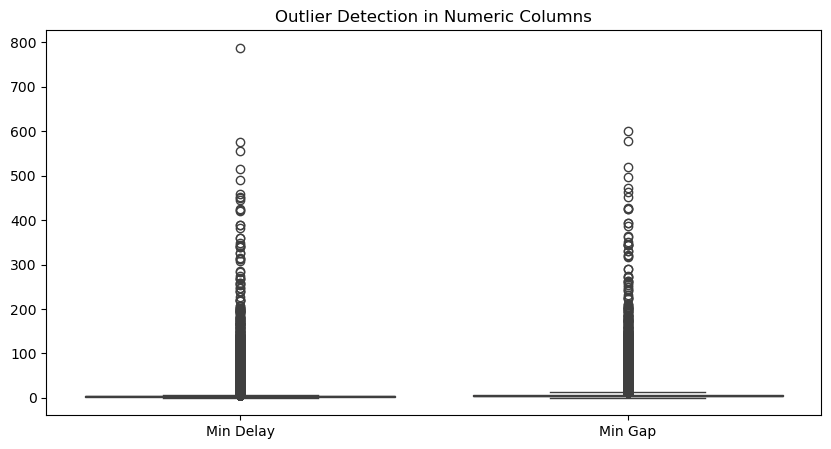

In [23]:
# Checking for outliers in Numeric Columns

# Boxplot to detect outliers
plt.figure(figsize=(10, 5))
sns.boxplot(data=df[["Min Delay", "Min Gap"]])
plt.title("Outlier Detection in Numeric Columns")
plt.show()


In [24]:
# As it can be seen from the boxplot, there are outliers in both "Min Delay" and "Min Gap" columns which can be removed

# Storing original dataset size before removing outliers
original_shape = df.shape
# Defining outlier threshold (removing top 1% extreme values)
min_delay_threshold = df["Min Delay"].quantile(0.99)
min_gap_threshold = df["Min Gap"].quantile(0.99)
# Counting outliers before removal
outliers_before = ((df["Min Delay"] > min_delay_threshold) | (df["Min Gap"] > min_gap_threshold)).sum()
# Printing count of outliers before removal
print(f"Total outliers in numeric columns before removal: {outliers_before}")
# Removing outliers (values above 99th percentile)
df_cleaned = df[(df["Min Delay"] <= min_delay_threshold) & (df["Min Gap"] <= min_gap_threshold)]
# Storing new dataset size after removal
new_shape = df_cleaned.shape
# Calculating how many outliers were removed
outliers_removed = original_shape[0] - new_shape[0]
print(f"Removed outliers in 'Min Delay' and 'Min Gap' (above 99th percentile).")
print(f"Total outliers removed: {outliers_removed}")
print(f"Original dataset shape: {original_shape}")
print(f"Updated dataset shape: {new_shape}")
df = df_cleaned

Total outliers in numeric columns before removal: 2012
Removed outliers in 'Min Delay' and 'Min Gap' (above 99th percentile).
Total outliers removed: 2012
Original dataset shape: (201279, 10)
Updated dataset shape: (199267, 10)


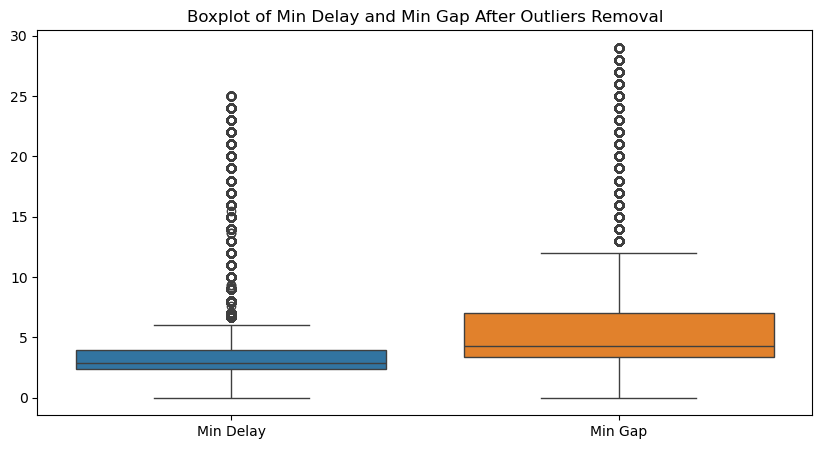

In [25]:
# Boxplot to visualize the distribution of "Min Delay" and "Min Gap" after outlier removal
plt.figure(figsize=(10, 5))
sns.boxplot(data=df[["Min Delay", "Min Gap"]])
plt.title("Boxplot of Min Delay and Min Gap After Outliers Removal")
plt.show()

In [26]:
df.head()

,Date,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle
1,2014-01-01,02:06:00,Wednesday,high park station,sudp,3.000000,7.000000,w,bd,5001.0
2,2014-01-01,02:40:00,Wednesday,sheppard station,munca,2.513655,3.747849,n,yu,0.0
3,2014-01-01,03:10:00,Wednesday,lansdowne station,sudp,3.000000,8.000000,w,bd,5116.0
4,2014-01-01,03:20:00,Wednesday,bloor station,musan,5.000000,10.000000,s,yu,5386.0
5,2014-01-01,03:29:00,Wednesday,dufferin station,mupaa,2.515239,3.667625,e,bd,5174.0


In [27]:
# Cleaning Date and Time Columns and Ensuring Correct Format
# Checking for missing values in "Date" and "Time"
date_missing = df["Date"].isnull().sum()
time_missing = df["Time"].isnull().sum()
print(f"Missing values in 'Date': {date_missing}")
print(f"Missing values in 'Time': {time_missing}")

# No missing values in "Date" and "Time" columns so we can proceed

Missing values in 'Date': 0
Missing values in 'Time': 0


In [28]:
# Checking for Invalid Dates (dataset starts from 2014 and ends at current date)

import datetime

# Define valid date range
min_valid_date = pd.Timestamp("2014-01-01")  # Start of dataset
max_valid_date = pd.Timestamp.today()        # Current date

# Counting invalid dates
invalid_dates_count = df[(df["Date"] < min_valid_date) | (df["Date"] > max_valid_date)].shape[0]

# Printing invalid dates count before removal
print(f"Total rows with invalid 'Date' values: {invalid_dates_count}")

# No invalid dates so we can proceed

Total rows with invalid 'Date' values: 0


In [29]:
# Cleaning up Vehicle Column

df["Vehicle"] = pd.to_numeric(df["Vehicle"], errors="coerce") # Converting "Vehicle" column to numeric for cleanup, forcing errors to NaN
invalid_vehicle_count = df[(df["Vehicle"].isna()) | (df["Vehicle"] <= 0)].shape[0] # Counting how many rows have invalid vehicle values (zero, negative, or NaN)
original_shape = df.shape # Storing the original shape before removal
df_cleaned = df[df["Vehicle"] > 0].copy() # Removing rows where "Vehicle" is zero, negative, or NaN
df_cleaned["Vehicle"] = df_cleaned["Vehicle"].astype(str) # Converting "Vehicle" column back to string after cleanup
new_shape = df_cleaned.shape # Storing the new shape after removal

print(f"Total rows removed due to invalid Vehicle values: {invalid_vehicle_count}")
print(f"Original dataset shape: {original_shape}")
print(f"Updated dataset shape: {new_shape}")

df = df_cleaned # Updating the dataset df with the cleaned version

Total rows removed due to invalid Vehicle values: 57896
Original dataset shape: (199267, 10)
Updated dataset shape: (141371, 10)


In [30]:
# Ensuring "Codes" are correct TTC codes

# List of valid codes per TTC documentation
valid_codes = [
    "euac", "eual", "euatc", "eubk", "eubo", "euca", "eucd", "euch", "euco", "eudo", "euecd", "euhv",
    "eult", "eulv", "eume", "eunea", "eunt", "euo", "euoe", "eoupo", "eupi", "eusc", "eutl", "eutm",
    "eutr", "eutrd", "euva", "euve", "euyrd", "muatc", "mucl", "mud", "mudd", "muec", "muesa", "mufm",
    "mufs", "mugd", "mui", "muie", "muir", "muirs", "muis", "muld", "munoa", "muo", "muodc", "mupaa",
    "mupla", "muplb", "muplc", "mupr1", "musan", "musc", "mutd", "muto", "muwea", "muwr", "puatc",
    "pucbi", "pucsc", "pucss", "pudcs", "pumel", "pumo", "pumst", "puopo", "pusac", "pusbe", "pusca",
    "puscr", "pusea", "pusi", "pusio", "pusis", "puslc", "pusnt", "puso", "pusra", "pussw", "pustc",
    "pustp", "pusts", "puswz", "puszc", "putcd", "putd", "putdn", "putij", "putis", "putnt", "puto",
    "putoe", "putr", "puts", "putsc", "putsm", "puttc", "puttp", "putwz", "suae", "suap", "subt",
    "sucol", "sudp", "sueas", "sug", "suo", "supol", "surob", "susa", "susp", "suut", "tuatc", "tucc",
    "tudoe", "tukey", "tuml", "tumvs", "tunip", "tunoa", "tuo", "tuopo", "tuos", "tus", "tusc", "tuset",
    "tust", "tusup", "erac", "erbo", "ercd", "erco", "erdb", "erdo", "erhv", "erlt", "erlv", "erme",
    "ernea", "ernt", "ero", "erpr", "erra", "ertb", "ertc", "ertl", "ertr", "erve", "erwa", "erws",
    "mrcl", "mrd", "mrdd", "mrec", "mresa", "mrfs", "mrie", "mrld", "mrnoa", "mro", "mrpaa", "mrpla",
    "mrplb", "mrplc", "mrpr1", "mrsan", "mrstm", "mrto", "mrui", "mruir", "mrwea", "prel", "pro",
    "prs", "prsa", "prsl", "prso", "prsp", "prst", "prsw", "prtst", "prw", "srae", "srap", "srbt",
    "srcol", "srdp", "sreas", "sro", "srsa", "srsp", "srut", "trdoe", "trnip", "trnoa", "tro",
    "trset", "trst", "trtc"
]

df["Code"] = df["Code"].astype(str).str.lower().str.strip() # ensuring "Code" column values to lowercase and strip extra spaces
original_shape = df.shape[0] # Store original shape before removal
df = df[df["Code"].isin(valid_codes)] # Remove rows where "Code" is not in the valid codes list
rows_removed = original_shape - df.shape[0] # Calculate number of rows removed
# Displaying updated dataframe shape and number of rows removed
print(f"Updated dataset shape after filtering invalid 'Code' values: {df.shape}")
print(f"Total rows removed: {rows_removed}")
df.head()

Updated dataset shape after filtering invalid 'Code' values: (141190, 10)
Total rows removed: 181


,Date,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle
1,2014-01-01,02:06:00,Wednesday,high park station,sudp,3.000000,7.000000,w,bd,5001.0
3,2014-01-01,03:10:00,Wednesday,lansdowne station,sudp,3.000000,8.000000,w,bd,5116.0
4,2014-01-01,03:20:00,Wednesday,bloor station,musan,5.000000,10.000000,s,yu,5386.0
5,2014-01-01,03:29:00,Wednesday,dufferin station,mupaa,2.515239,3.667625,e,bd,5174.0
13,2014-01-01,08:49:00,Wednesday,sheppard-yonge station,munoa,6.000000,12.000000,e,shp,5276.0


Initial Descriptive Statistics

In [31]:
# Unique values in Station, Code, Bound and Line COlumns

# Count unique values in specified columns
unique_station_count = df["Station"].nunique()
unique_code_count = df["Code"].nunique()
unique_bound_count = df["Bound"].nunique()
unique_line_count = df["Line"].nunique()

# Print results
print(f"Unique 'Station' values: {unique_station_count}")
print(f"Unique 'Code' values: {unique_code_count}")
print(f"Unique 'Bound' values: {unique_bound_count}")
print(f"Unique 'Line' values: {unique_line_count}")


Unique 'Station' values: 97
Unique 'Code' values: 190
Unique 'Bound' values: 4
Unique 'Line' values: 38


In [32]:
# Descriptive statistics for "Min Delay" grouped by predictors

# Mean, Median, and Variance of "Min Delay" by "Time"
time_stats = df.groupby("Time")["Min Delay"].agg(["mean", "median", "var"]).reset_index()

# Mean, Median, and Variance of "Min Delay" by "Date"
date_stats = df.groupby("Date")["Min Delay"].agg(["mean", "median", "var"]).reset_index()

# Mean, Median, and Variance of "Min Delay" by "Station"
station_stats = df.groupby("Station")["Min Delay"].agg(["mean", "median", "var"]).reset_index()

# Mean, Median, and Variance of "Min Delay" by "Bound"
bound_stats = df.groupby("Bound")["Min Delay"].agg(["mean", "median", "var"]).reset_index()

# Mean, Median, and Variance of "Min Delay" by "Line"
line_stats = df.groupby("Line")["Min Delay"].agg(["mean", "median", "var"]).reset_index()

# Mean, Median, and Variance of "Min Delay" by "Code"
code_stats = df.groupby("Code")["Min Delay"].agg(["mean", "median", "var"]).reset_index()

# Displaying the results
descriptive_stats = {
    "Descriptive Stats by Time": time_stats,
    "Descriptive Stats by Date": date_stats,
    "Descriptive Stats by Station": station_stats,
    "Descriptive Stats by Bound": bound_stats,
    "Descriptive Stats by Line": line_stats,
    "Descriptive Stats by Code": code_stats
}

# Display data tables
for name, stats in descriptive_stats.items():
    print(f"\n{name}:\n")
    print(stats.head(20))  # Displaying only first 20 rows of each stats table
    print("\n" + "-"*50)



Descriptive Stats by Time:

        Time      mean    median        var
0   00:00:00  5.479591  4.000000  22.906531
1   00:01:00  5.209297  4.000000  14.241898
2   00:02:00  4.888923  3.020157  15.166209
3   00:03:00  5.640723  4.000000  17.535274
4   00:04:00  4.558085  3.000000  10.829065
5   00:05:00  4.781628  3.482029  12.896459
6   00:06:00  5.180579  4.000000  19.917980
7   00:07:00  4.468704  3.550499   8.573509
8   00:08:00  5.340110  4.000000  17.256776
9   00:09:00  4.633545  3.002021  10.419122
10  00:10:00  4.914107  3.097533  12.596059
11  00:11:00  4.998376  4.000000  11.163847
12  00:12:00  4.148538  3.000000   7.434432
13  00:13:00  5.296022  3.063313  16.944278
14  00:14:00  4.324964  3.000000   9.266921
15  00:15:00  4.773066  3.000000  13.826730
16  00:16:00  4.852269  4.000000  13.173676
17  00:17:00  4.210474  3.000000   9.372439
18  00:18:00  4.265747  3.016568   5.482106
19  00:19:00  5.122792  4.000000  11.686779

----------------------------------------------

In [33]:
# Extracting year and month from "Date" for grouping
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month

# Compute descriptive statistics for "Min Delay" on a yearly basis
yearly_stats = df.groupby("Year")["Min Delay"].agg(["mean", "median", "var"]).reset_index()

# Compute descriptive statistics for "Min Delay" on a monthly basis
monthly_stats = df.groupby(["Year", "Month"])["Min Delay"].agg(["mean", "median", "var"]).reset_index()

# Print results
print("\nDescriptive Stats by Year:\n", yearly_stats)
print("\nDescriptive Stats by Month:\n", monthly_stats)



Descriptive Stats by Year:
     Year      mean    median        var
0   2014  3.708415  2.979632   6.811780
1   2015  3.392356  2.742429   6.016804
2   2016  3.555944  2.854238   6.940692
3   2017  3.678006  2.952954   7.027900
4   2018  3.854416  3.000000   8.054464
5   2019  3.902593  3.000000   8.233315
6   2020  4.365054  3.000000  10.036778
7   2021  4.676403  3.000000  12.184454
8   2022  4.938212  3.029094  13.837327
9   2023  5.018874  3.413559  15.086085
10  2024  4.743377  3.000000  13.771510
11  2025  4.873421  3.097533  14.618633

Descriptive Stats by Month:
      Year  Month      mean    median        var
0    2014      1  3.911673  3.000000   7.536486
1    2014      2  3.607929  3.000000   5.556634
2    2014      3  3.679397  3.000000   5.557049
3    2014      4  3.791285  3.000000   7.651896
4    2014      5  3.682252  2.979632   5.975502
..    ...    ...       ...       ...        ...
120  2024      9  4.609598  3.000000  12.903558
121  2024     10  4.886206  3.000000 

C:\Users\ifara\AppData\Local\Temp\ipykernel_3816\2949388045.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Year"] = df["Date"].dt.year
C:\Users\ifara\AppData\Local\Temp\ipykernel_3816\2949388045.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Month"] = df["Date"].dt.month


In [34]:
# Dividing into Rush Hour and Non-Rush Hour
# Rush Hour data frame has been saved as df_rush and non-rush hour data frame has been saved as df_non_rush

# Creating a new column for cleaned time format
df["Time_STR"] = df["Time"].astype(str).str.strip()

# Extracting hour safely by splitting on ":" and taking the first part
df["Hour"] = df["Time_STR"].apply(lambda x: int(x.split(":")[0]) if ":" in x and x.split(":")[0].isdigit() else None)

# Removing rows where "Hour" is missing or could not be extracted
df = df.dropna(subset=["Hour"])

# Defining rush hour based on the "Day" column
def is_rush_hour(row):
    weekday_rush = (row["Hour"] >= 6 and row["Hour"] <= 9) or (row["Hour"] >= 16 and row["Hour"] <= 19)
    weekend_rush = (row["Hour"] >= 10 and row["Hour"] <= 14) or (row["Hour"] >= 17 and row["Hour"] <= 19)

    if row["Day"].lower() in ["monday", "tuesday", "wednesday", "thursday", "friday"]:
        return 1 if weekday_rush else 0
    elif row["Day"].lower() in ["saturday", "sunday"]:
        return 1 if weekend_rush else 0
    return 0

df["RushHour"] = df.apply(is_rush_hour, axis=1)

# Defining non-rush hour (Opposite of Rush Hour)
df["NonRushHour"] = df["RushHour"].apply(lambda x: 1 if x == 0 else 0)

# separate dataframes for rush hour and non-rush hour created
df_rush = df[df["RushHour"] == 1].copy()
df_non_rush = df[df["NonRushHour"] == 1].copy()


print("Rush Hour Data:")
print(df_rush.head())
print("\nNon-Rush Hour Data:")
print(df_non_rush.head())



C:\Users\ifara\AppData\Local\Temp\ipykernel_3816\2475933983.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Time_STR"] = df["Time"].astype(str).str.strip()
C:\Users\ifara\AppData\Local\Temp\ipykernel_3816\2475933983.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Hour"] = df["Time_STR"].apply(lambda x: int(x.split(":")[0]) if ":" in x and x.split(":")[0].isdigit() else None)


Rush Hour Data:
         Date      Time        Day                 Station   Code  Min Delay  \
13 2014-01-01  08:49:00  Wednesday  sheppard-yonge station  munoa   6.000000   
14 2014-01-01  08:53:00  Wednesday      st patrick station   tusc   2.652624   
15 2014-01-01  08:55:00  Wednesday  sheppard-yonge station  munoa  12.000000   
24 2014-01-01  09:38:00  Wednesday             bay station   sudp   5.000000   
25 2014-01-01  09:38:00  Wednesday           finch station  munoa   1.990594   

      Min Gap Bound Line Vehicle  Year  Month  Time_STR  Hour  RushHour  \
13  12.000000     e  shp  5276.0  2014      1  08:49:00     8         1   
14   3.760359     s   yu  5611.0  2014      1  08:53:00     8         1   
15  18.000000     e  shp  5282.0  2014      1  08:55:00     8         1   
24  10.000000     e   bd  5214.0  2014      1  09:38:00     9         1   
25   3.297401     s   yu  5681.0  2014      1  09:38:00     9         1   

    NonRushHour  
13            0  
14            0 

In [35]:
# Counting unique values
unique_station_count_rush = df_rush["Station"].nunique()
unique_code_count_rush = df_rush["Code"].nunique()
unique_bound_count_rush = df_rush["Bound"].nunique()
unique_line_count_rush = df_rush["Line"].nunique()

unique_station_count_non = df_non_rush["Station"].nunique()
unique_code_count_non = df_non_rush["Code"].nunique()
unique_bound_count_non = df_non_rush["Bound"].nunique()
unique_line_count_non = df_non_rush["Line"].nunique()

# Printing the results
print("Rush Hour Data:")
print(f"Unique 'Station' values: {unique_station_count_rush}")
print(f"Unique 'Code' values: {unique_code_count_rush}")
print(f"Unique 'Bound' values: {unique_bound_count_rush}")
print(f"Unique 'Line' values: {unique_line_count_rush}")

print("\nNon-Rush Hour Data:")
print(f"Unique 'Station' values: {unique_station_count_non}")
print(f"Unique 'Code' values: {unique_code_count_non}")
print(f"Unique 'Bound' values: {unique_bound_count_non}")
print(f"Unique 'Line' values: {unique_line_count_non}")

Rush Hour Data:
Unique 'Station' values: 88
Unique 'Code' values: 186
Unique 'Bound' values: 4
Unique 'Line' values: 20

Non-Rush Hour Data:
Unique 'Station' values: 92
Unique 'Code' values: 185
Unique 'Bound' values: 4
Unique 'Line' values: 26


In [36]:
# Descriptive statistics for "Min Delay" on rush hour data grouped by predictors
rush_station_stats = df_rush.groupby("Station")["Min Delay"].agg(["mean", "median", "var"]).reset_index()
rush_bound_stats = df_rush.groupby("Bound")["Min Delay"].agg(["mean", "median", "var"]).reset_index()
rush_line_stats = df_rush.groupby("Line")["Min Delay"].agg(["mean", "median", "var"]).reset_index()
rush_code_stats = df_rush.groupby("Code")["Min Delay"].agg(["mean", "median", "var"]).reset_index()
rush_day_stats = df_rush.groupby("Day")["Min Delay"].agg(["mean", "median", "var"]).reset_index()

# Descriptive statistics for "Min Delay" on non-rush hour data grouped by predictors
non_rush_station_stats = df_non_rush.groupby("Station")["Min Delay"].agg(["mean", "median", "var"]).reset_index()
non_rush_bound_stats = df_non_rush.groupby("Bound")["Min Delay"].agg(["mean", "median", "var"]).reset_index()
non_rush_line_stats = df_non_rush.groupby("Line")["Min Delay"].agg(["mean", "median", "var"]).reset_index()
non_rush_code_stats = df_non_rush.groupby("Code")["Min Delay"].agg(["mean", "median", "var"]).reset_index()
non_rush_day_stats = df_non_rush.groupby("Day")["Min Delay"].agg(["mean", "median", "var"]).reset_index()

# Print results for Rush Hour
print("\nDescriptive Stats for Rush Hour by Station:\n", rush_station_stats.head(10))
print("\nDescriptive Stats for Rush Hour by Bound:\n", rush_bound_stats)
print("\nDescriptive Stats for Rush Hour by Line:\n", rush_line_stats)
print("\nDescriptive Stats for Rush Hour by Code:\n", rush_code_stats.head(10))
print("\nDescriptive Stats for Rush Hour by Day:\n", rush_day_stats)

# Print results for Non-Rush Hour
print("\nDescriptive Stats for Non-Rush Hour by Station:\n", non_rush_station_stats.head(10))
print("\nDescriptive Stats for Non-Rush Hour by Bound:\n", non_rush_bound_stats)
print("\nDescriptive Stats for Non-Rush Hour by Line:\n", non_rush_line_stats)
print("\nDescriptive Stats for Non-Rush Hour by Code:\n", non_rush_code_stats.head(10))
print("\nDescriptive Stats for Non-Rush Hour by Day:\n", non_rush_day_stats)



Descriptive Stats for Rush Hour by Station:
                 Station      mean    median        var
0      bathurst station  4.120228  3.000000  12.499838
1           bay station  4.740101  3.000000  14.026817
2       bayview station  4.834405  3.550499   8.902244
3     bessarion station  4.884438  3.319923   9.602270
4         bloor station  3.794009  3.000000   8.949586
5   bloor-yonge station  4.318127  3.000000   8.740915
6     broadview station  4.461613  3.000000  10.402444
7  castle frank station  5.258100  4.157856  10.383818
8       chester station  4.009992  2.485095   9.566250
9      christie station  3.768443  2.298416   9.262241

Descriptive Stats for Rush Hour by Bound:
   Bound      mean    median       var
0     e  3.660859  2.742429  8.614547
1     n  4.358256  3.000000  9.941921
2     s  4.145193  3.000000  8.172437
3     w  3.670695  2.742429  8.783773

Descriptive Stats for Rush Hour by Line:
                       Line      mean    median        var
0             

In [37]:
# Descriptive Statistics for "Min Delay" by Rush Hour and Non-Rush Hour (Yearly and Monthly)

# Descriptive statistics for "Min Delay" on a yearly basis for rush hour data
rush_yearly_stats = df_rush.groupby("Year")["Min Delay"].agg(["mean", "median", "var"]).reset_index()

# Descriptive statistics for "Min Delay" on a monthly basis for rush hour data
rush_monthly_stats = df_rush.groupby(["Year", "Month"])["Min Delay"].agg(["mean", "median", "var"]).reset_index()

# Descriptive statistics for "Min Delay" on a yearly basis for non-rush hour data
non_rush_yearly_stats = df_non_rush.groupby("Year")["Min Delay"].agg(["mean", "median", "var"]).reset_index()

# Descriptive statistics for "Min Delay" on a monthly basis for non-rush hour data
non_rush_monthly_stats = df_non_rush.groupby(["Year", "Month"])["Min Delay"].agg(["mean", "median", "var"]).reset_index()

# Printing results for Rush Hour
print("\nDescriptive Stats for Rush Hour by Year:\n", rush_yearly_stats)
print("\nDescriptive Stats for Rush Hour by Month:\n", rush_monthly_stats.head(20))

# Printing results for Non-Rush Hour
print("\nDescriptive Stats for Non-Rush Hour by Year:\n", non_rush_yearly_stats)
print("\nDescriptive Stats for Non-Rush Hour by Month:\n", non_rush_monthly_stats.head(20))



Descriptive Stats for Rush Hour by Year:
     Year      mean    median        var
0   2014  3.628910  3.000000   6.337672
1   2015  3.319613  2.742429   5.526326
2   2016  3.438994  2.831049   5.941361
3   2017  3.549163  2.911072   6.485267
4   2018  3.693088  3.000000   6.592728
5   2019  3.776306  3.000000   7.277097
6   2020  4.239892  3.000000   9.774926
7   2021  4.526014  3.000000  11.547736
8   2022  4.726802  3.000000  12.822991
9   2023  4.713572  3.000000  13.140818
10  2024  4.570669  3.000000  12.380636
11  2025  4.846760  3.000000  15.628083

Descriptive Stats for Rush Hour by Month:
     Year  Month      mean    median       var
0   2014      1  3.815357  3.000000  7.044466
1   2014      2  3.481289  3.000000  4.537203
2   2014      3  3.530766  3.000000  4.686124
3   2014      4  3.792777  3.000000  7.813534
4   2014      5  3.537146  2.979632  4.890076
5   2014      6  3.637826  2.979632  6.897366
6   2014      7  3.760948  3.000000  7.654543
7   2014      8  3.520418

In [38]:
# Summary Statistics
print("\nSummary Statistics for All Data:\n")
print(df.describe(include="all"))
print("\nSummary Statistics for Rush Hour Data:\n")
print(df_rush.describe(include="all"))
print("\nSummary Statistics for non-Rush Hour Data:\n")
print(df_non_rush.describe(include="all"))


Summary Statistics for All Data:

                                 Date      Time       Day          Station  \
count                          141190    141190    141190           141190   
unique                            NaN      1421         7               97   
top                               NaN  05:55:00  Thursday  kennedy station   
freq                              NaN       263     22279             7237   
mean    2019-05-15 06:47:31.952687872       NaN       NaN              NaN   
min               2014-01-01 00:00:00       NaN       NaN              NaN   
25%               2016-04-08 00:00:00       NaN       NaN              NaN   
50%               2019-03-13 00:00:00       NaN       NaN              NaN   
75%               2022-06-10 18:00:00       NaN       NaN              NaN   
max               2025-01-31 00:00:00       NaN       NaN              NaN   
std                               NaN       NaN       NaN              NaN   

          Code      Min Dela

In [39]:
#Added it to get rid of error-Peeu
!pip install xlsxwriter

# Outputting all statistics to an Excel File for Reporting

# Defining the file name for the output Excel file
output_file = "TTC_Subway_Delay_Statistics.xlsx"

# dictionary of dataframes with shorter sheet names creation
dataframes = {
    "Unique Values": pd.DataFrame({
        "Category": ["Station", "Code", "Bound", "Line"],
        "Unique Values": [unique_station_count, unique_code_count, unique_bound_count, unique_line_count]
    }),
    "Stats by Time": time_stats,
    "Stats by Date": date_stats,
    "Stats by Station": station_stats,
    "Stats by Bound": bound_stats,
    "Stats by Line": line_stats,
    "Stats by Code": code_stats,
    "Stats by Year": yearly_stats,
    "Stats by Month": monthly_stats,
    "Rush Stats Station": rush_station_stats,
    "Rush Stats Bound": rush_bound_stats,
    "Rush Stats Line": rush_line_stats,
    "Rush Stats Code": rush_code_stats,
    "Rush Stats Day": rush_day_stats,
    "Non-Rush Stats Station": non_rush_station_stats,
    "Non-Rush Stats Bound": non_rush_bound_stats,
    "Non-Rush Stats Line": non_rush_line_stats,
    "Non-Rush Stats Code": non_rush_code_stats,
    "Non-Rush Stats Day": non_rush_day_stats,
    "Rush Stats Year": rush_yearly_stats,
    "Rush Stats Month": rush_monthly_stats,
    "Non-Rush Stats Year": non_rush_yearly_stats,
    "Non-Rush Stats Month": non_rush_monthly_stats,
    "Summary All Data": df.describe(include="all"),
    "Summary Rush Hour": df_rush.describe(include="all"),
    "Summary Non-Rush": df_non_rush.describe(include="all"),
}

# generating Excel file with multiple sheets
with pd.ExcelWriter(output_file, engine="xlsxwriter") as writer:
    for sheet_name, dataframe in dataframes.items():
        dataframe.to_excel(writer, sheet_name=sheet_name, index=False)

print(f"Excel file '{output_file}' has been created successfully!")


Excel file 'TTC_Subway_Delay_Statistics.xlsx' has been created successfully!


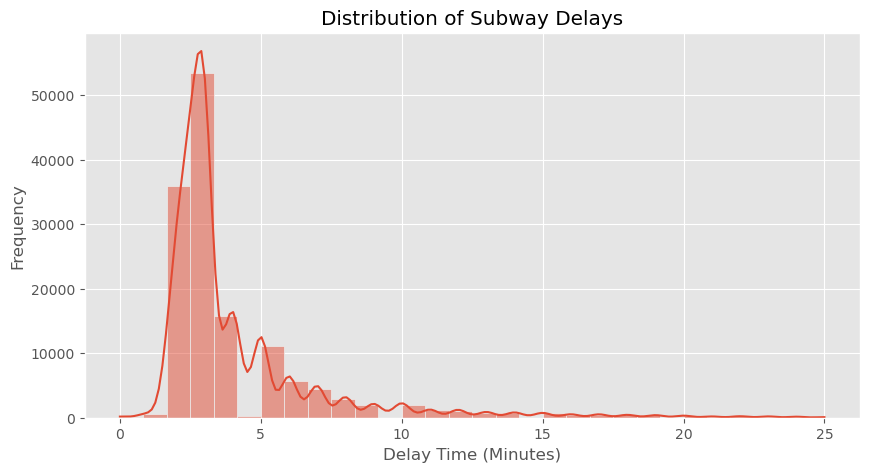

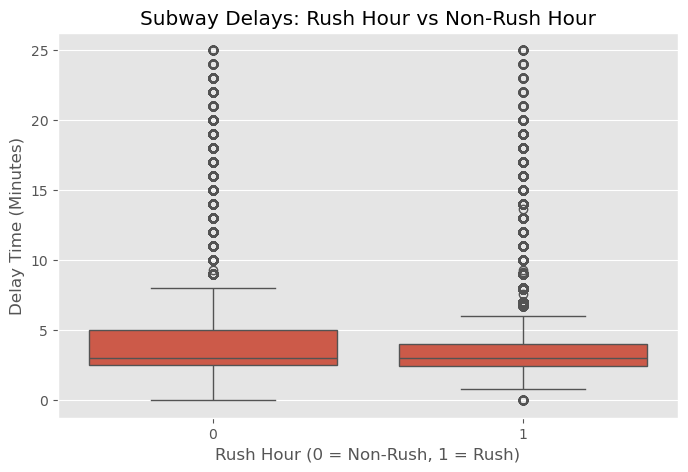

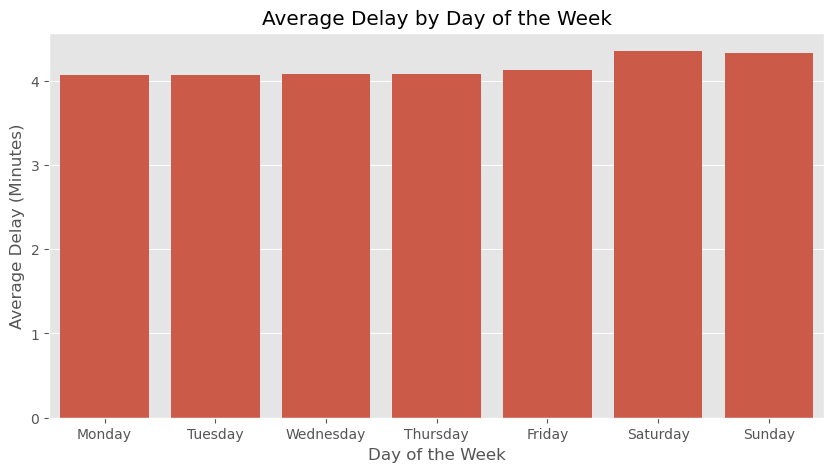

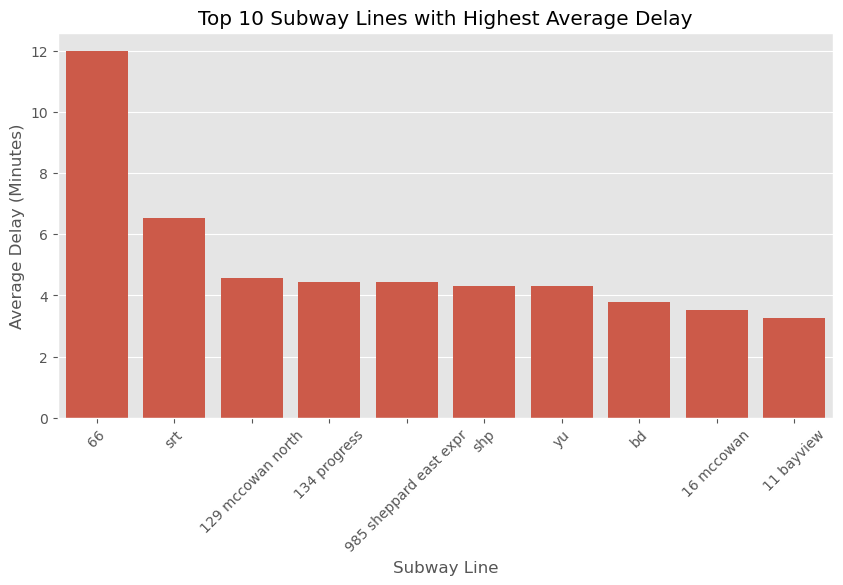

C:\Users\ifara\AppData\Local\Temp\ipykernel_3816\2066857566.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_top_lines["Line"], y=df_top_lines["Min Delay"], palette="coolwarm") #swarm plot


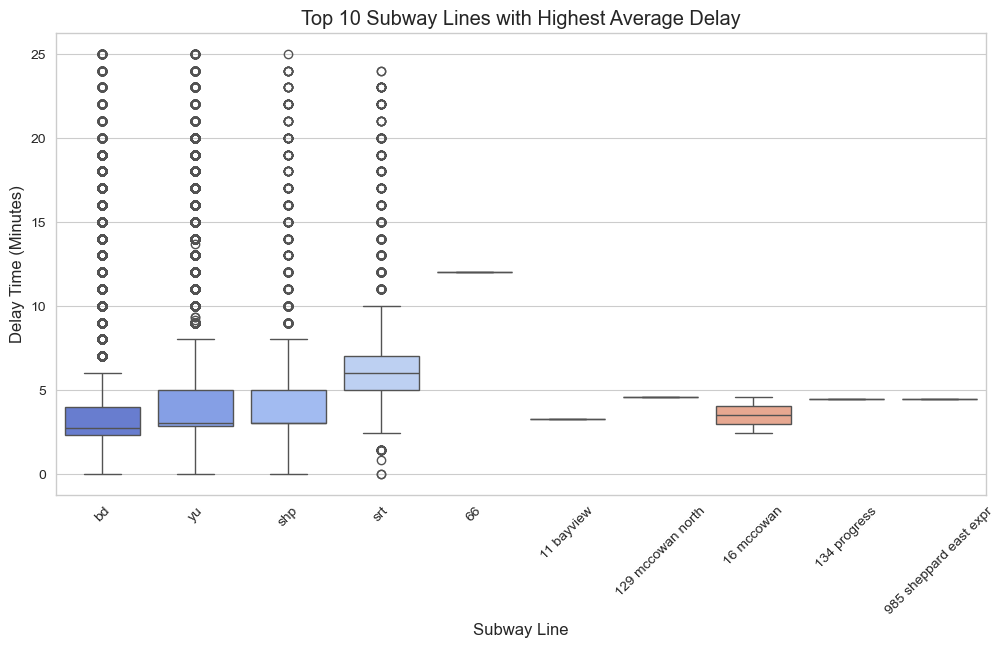

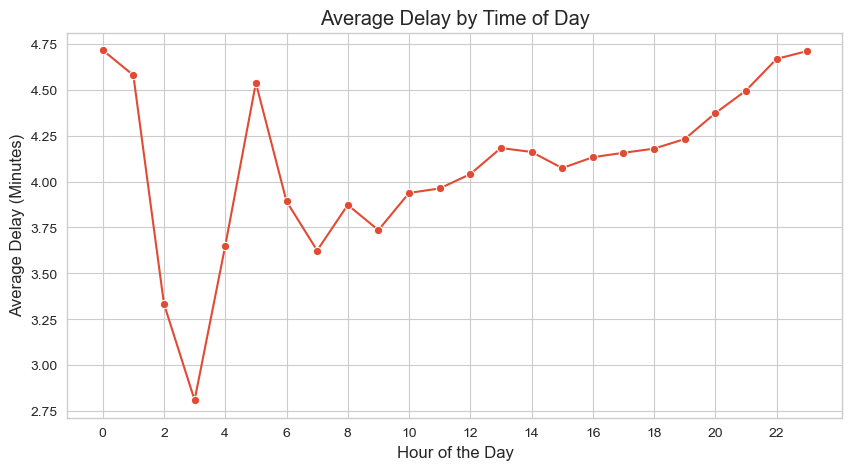

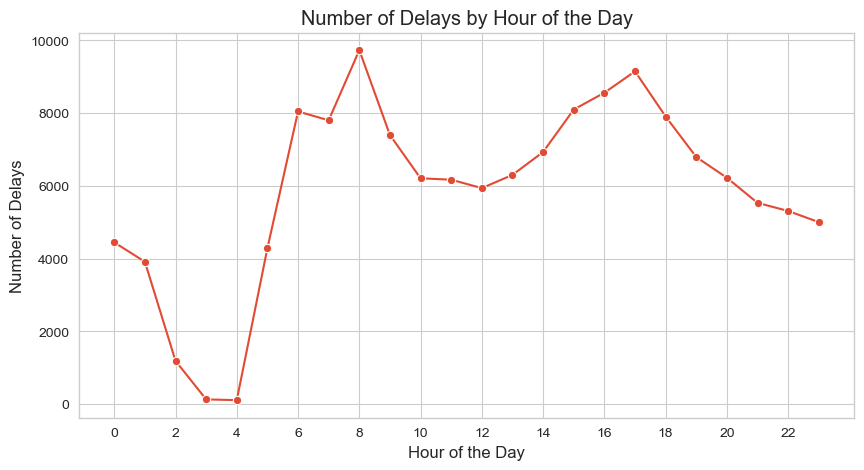

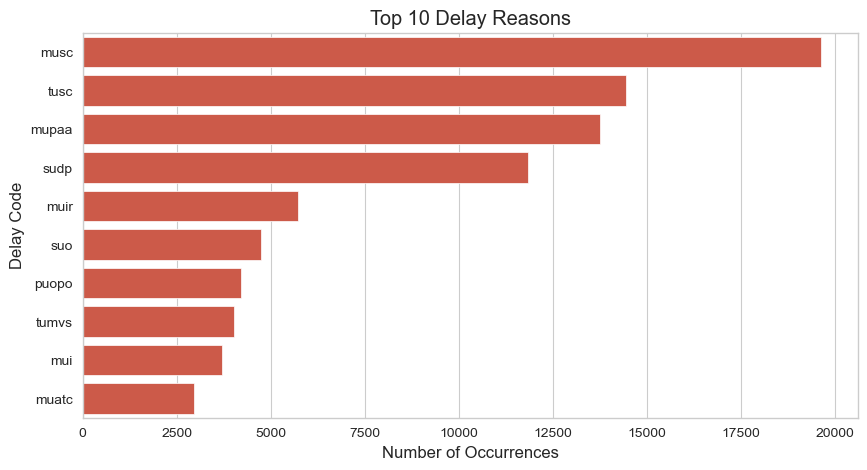

C:\Users\ifara\AppData\Local\Temp\ipykernel_3816\2066857566.py:97: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_delayed_reasons.values, y=top_delayed_reasons.index, palette="magma")


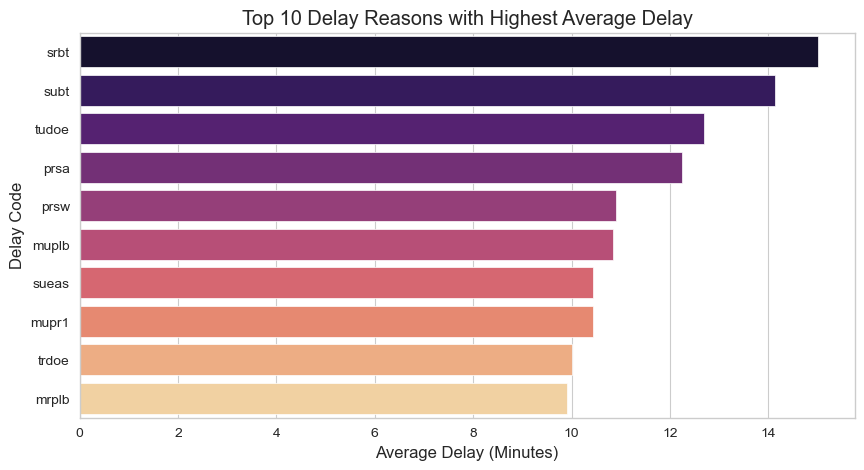

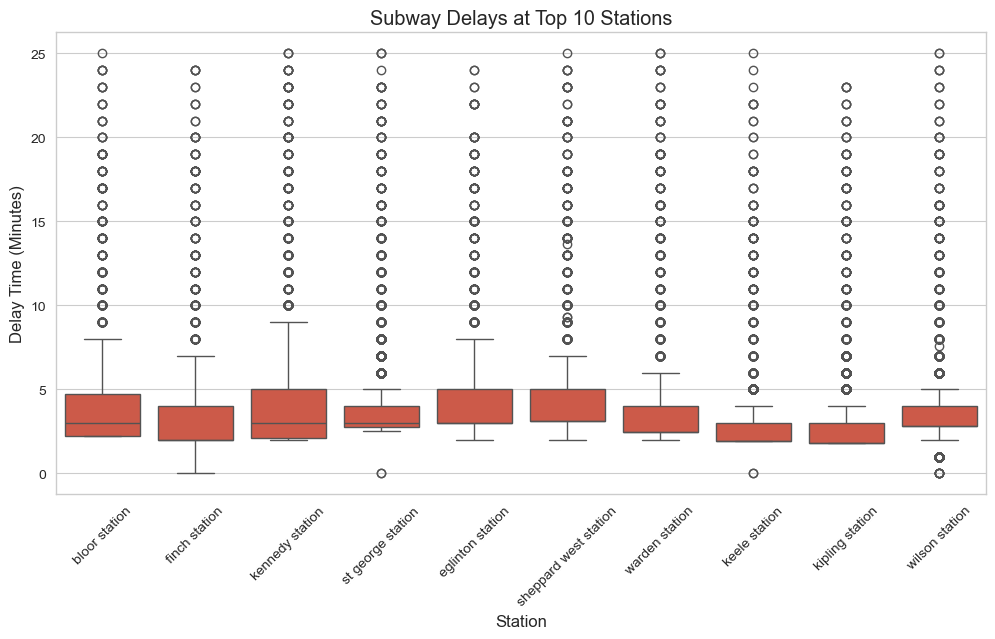

C:\Users\ifara\AppData\Local\Temp\ipykernel_3816\2066857566.py:120: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_delayed_stations.values, y=top_delayed_stations.index, palette="magma")


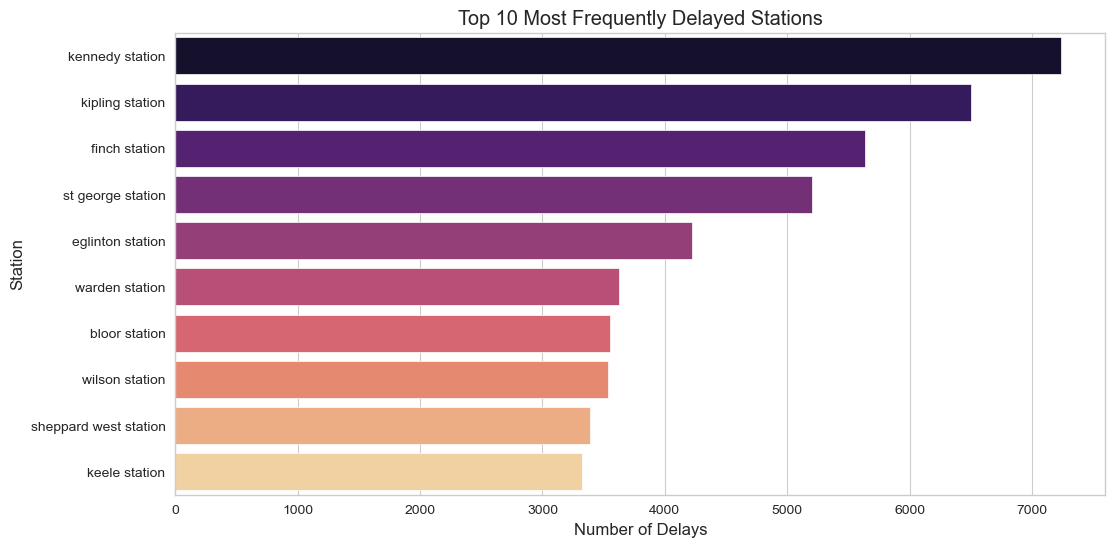

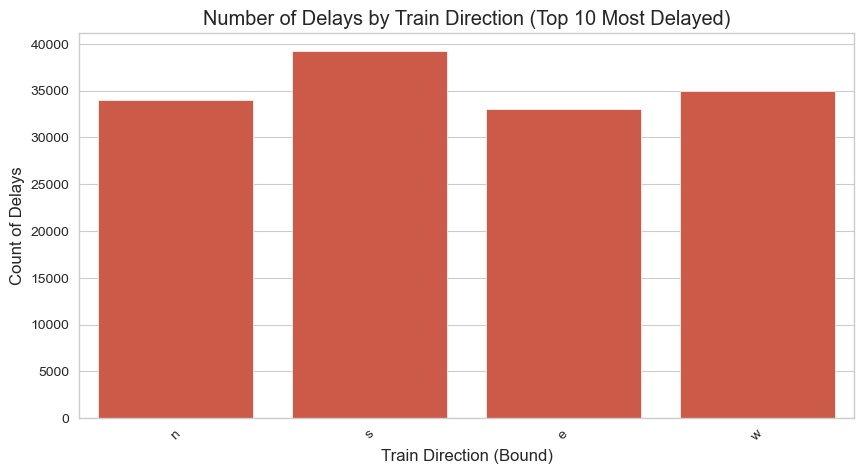

C:\Users\ifara\AppData\Local\Temp\ipykernel_3816\2066857566.py:142: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bound_avg_delay.index, y=bound_avg_delay.values, palette="viridis") #bar chart


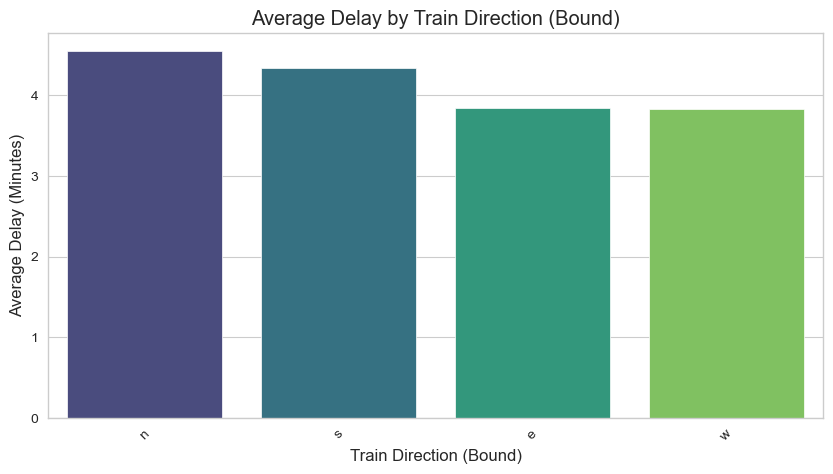

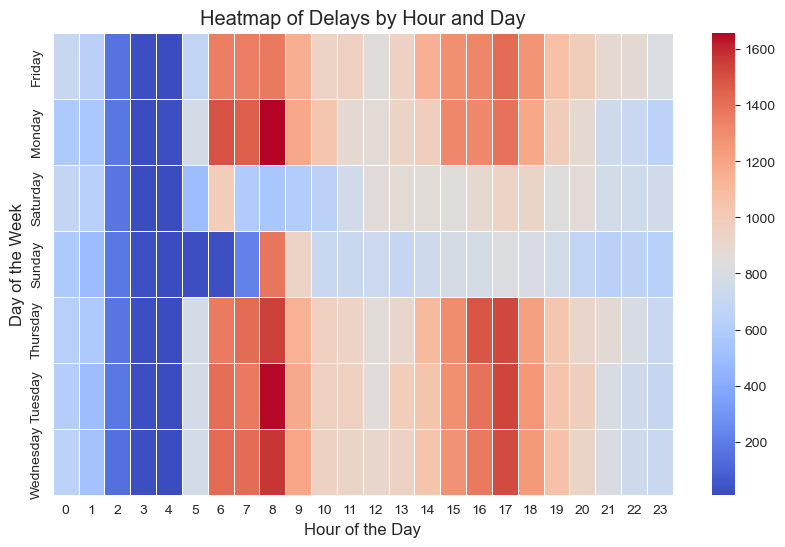

C:\Users\ifara\AppData\Local\Temp\ipykernel_3816\2066857566.py:163: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_delayed_vehicles.index, y=top_delayed_vehicles.values, palette="coolwarm")


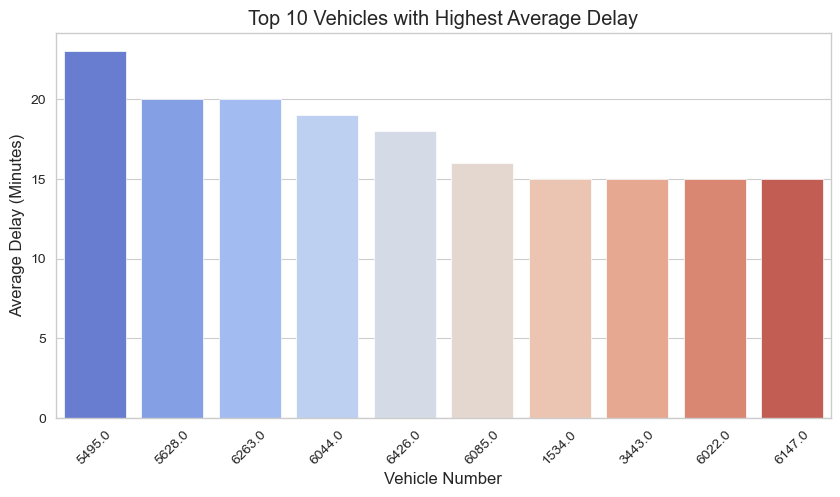

In [40]:
# Visualization - Initial Exploratory Data Analysis

# visualization styles
plt.style.use("ggplot")

# 1. Histogram of Subway Delays
plt.figure(figsize=(10, 5))
sns.histplot(df["Min Delay"], bins=30, kde=True)
plt.title("Distribution of Subway Delays")
plt.xlabel("Delay Time (Minutes)")
plt.ylabel("Frequency")
plt.savefig("plot1.jpg", dpi=300, bbox_inches="tight") #Save Plot
plt.show() #Show Plot

# 2. Boxplot - Rush Hour vs Non-Rush Hour Delays
plt.figure(figsize=(8, 5))
sns.boxplot(x=df["RushHour"], y=df["Min Delay"])
plt.title("Subway Delays: Rush Hour vs Non-Rush Hour")
plt.xlabel("Rush Hour (0 = Non-Rush, 1 = Rush)")
plt.ylabel("Delay Time (Minutes)")
plt.savefig("plot2.jpg", dpi=300, bbox_inches="tight") #Save Plot
plt.show()

# 3. Bar Chart - Average Delay by Day of the Week
weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"] # Define order of weekdays (Monday to Sunday)
day_avg_delay = df.groupby("Day")["Min Delay"].mean().reindex(weekday_order) # average delay per day
plt.figure(figsize=(10, 5)) # bar chart for average delay by day of the week
sns.barplot(x=day_avg_delay.index, y=day_avg_delay.values)
plt.title("Average Delay by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Average Delay (Minutes)")
plt.savefig("plot3.jpg", dpi=300, bbox_inches="tight") #Save Plot
plt.show()

# 4. Average Delay by Subway Line
top_delayed_lines = df.groupby("Line")["Min Delay"].mean().nlargest(10) # top 10 subway lines with the highest average delay
plt.figure(figsize=(10, 5)) # bar chart for top 10 delayed subway lines
sns.barplot(x=top_delayed_lines.index, y=top_delayed_lines.values)
plt.title("Top 10 Subway Lines with Highest Average Delay")
plt.xlabel("Subway Line")
plt.ylabel("Average Delay (Minutes)")
plt.xticks(rotation=45) # Rotated x-axis labels for readability
plt.savefig("plot4.jpg", dpi=300, bbox_inches="tight") #Save Plot
plt.show()

# 5. Distribution of Delays by Subway Line
sns.set_style("whitegrid")
top_delayed_lines = df.groupby("Line")["Min Delay"].mean().nlargest(10).index # top 10 subway lines with the highest average delay
df_top_lines = df[df["Line"].isin(top_delayed_lines)] # Filter the dataset for only top 10 most delayed subway lines
plt.figure(figsize=(12, 6)) #swarm plot
sns.boxplot(x=df_top_lines["Line"], y=df_top_lines["Min Delay"], palette="coolwarm") #swarm plot
plt.title("Top 10 Subway Lines with Highest Average Delay")
plt.xlabel("Subway Line")
plt.ylabel("Delay Time (Minutes)")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.savefig("plot5.jpg", dpi=300, bbox_inches="tight") #Save Plot
plt.show()

# 6. Line Chart - Average Delay by Hour of the Day
hour_avg_delay = df.groupby("Hour")["Min Delay"].mean() #average delay by hour of the day
plt.figure(figsize=(10, 5)) #line chart
sns.lineplot(x=hour_avg_delay.index, y=hour_avg_delay.values, marker="o") #line chart
plt.title("Average Delay by Time of Day")
plt.xlabel("Hour of the Day")
plt.ylabel("Average Delay (Minutes)")
plt.xticks(ticks=range(0, 24, 2))  # Show labels every 2 hours for better readability
plt.grid(True)
plt.savefig("plot6.jpg", dpi=300, bbox_inches="tight") #Save Plot
plt.show()

# 7. Line Chart - Number of Delays by Hour of the Day
hourly_delays = df.groupby("Hour")["Min Delay"].count() #number of delays by hour of the day
plt.figure(figsize=(10, 5))
sns.lineplot(x=hourly_delays.index, y=hourly_delays.values, marker="o")
# Formatting
plt.title("Number of Delays by Hour of the Day")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Delays")
plt.xticks(ticks=range(0, 24, 2))  # Show labels every 2 hours for better readability
plt.grid(True)
plt.savefig("plot7.jpg", dpi=300, bbox_inches="tight") #Save Plot
plt.show()

# 8. Bar Chart - Top 10 Delay Reasons (Code)
top_delay_codes = df["Code"].value_counts().nlargest(10) # 10 most common delay reasons (codes)
plt.figure(figsize=(10, 5)) # bar chart
sns.barplot(x=top_delay_codes.values, y=top_delay_codes.index) # bar chart
plt.title("Top 10 Delay Reasons")
plt.xlabel("Number of Occurrences")
plt.ylabel("Delay Code")
plt.savefig("plot8.jpg", dpi=300, bbox_inches="tight") #Save Plot
plt.show()

# 9. Plot of Average Delay for the Top 10 Delay Codes
top_delayed_reasons = df.groupby("Code")["Min Delay"].mean().nlargest(10) #top 10 delay reasons with the highest average delay
plt.figure(figsize=(10, 5)) #bar chart
sns.barplot(x=top_delayed_reasons.values, y=top_delayed_reasons.index, palette="magma")
plt.title("Top 10 Delay Reasons with Highest Average Delay")
plt.xlabel("Average Delay (Minutes)")
plt.ylabel("Delay Code")
plt.savefig("plot9.jpg", dpi=300, bbox_inches="tight") #Save Plot
plt.show()

# 10. Boxplot of Subway Delays by Station (Top 10 stations with most delays)
df["Station"] = df["Station"].astype(str) # Ensure "Station" column is a string
top_stations = df["Station"].value_counts().nlargest(10).index # Get the top 10 most delayed stations
df_top_stations = df[df["Station"].isin(top_stations)] # Filter the dataset for only top stations
plt.figure(figsize=(12, 6)) # Create the boxplot
sns.boxplot(x="Station", y="Min Delay", data=df_top_stations)
plt.title("Subway Delays at Top 10 Stations") # Formatting
plt.xlabel("Station") # Formatting
plt.ylabel("Delay Time (Minutes)") # Formatting
plt.xticks(rotation=45) # Formatting
plt.savefig("plot10.jpg", dpi=300, bbox_inches="tight") #Save Plot
plt.show()

# 11. Plot of Most Frequently Delayed Stations
top_delayed_stations = df["Station"].value_counts().nlargest(10) #top 10 stations with the highest number of delays
plt.figure(figsize=(12, 6))
sns.barplot(x=top_delayed_stations.values, y=top_delayed_stations.index, palette="magma")
plt.title("Top 10 Most Frequently Delayed Stations")
plt.xlabel("Number of Delays")
plt.ylabel("Station")
plt.savefig("plot11.jpg", dpi=300, bbox_inches="tight") #Save Plot
plt.show()

# 12. Number of Delays by Bound Direction
top_delayed_bounds = df.groupby("Bound")["Min Delay"].mean().nlargest(10).index # "Bound" values with the highest average delay
df_top_delayed_bounds = df[df["Bound"].isin(top_delayed_bounds)] # Filtering the dataset for most delayed "Bound" values
plt.figure(figsize=(10, 5)) # countplot for most delayed train directions (Bound)
sns.countplot(x=df_top_delayed_bounds["Bound"], order=top_delayed_bounds) # countplot for most delayed train directions (Bound)
plt.title("Number of Delays by Train Direction (Top 10 Most Delayed)")
plt.xlabel("Train Direction (Bound)")
plt.ylabel("Count of Delays")
plt.xticks(rotation=45) # Rotated x-axis labels for readability
plt.savefig("plot12.jpg", dpi=300, bbox_inches="tight") #Save Plot
plt.show()

# 13. Average delay by train direction (Bound)
bound_avg_delay = df.groupby("Bound")["Min Delay"].mean().sort_values(ascending=False)
plt.figure(figsize=(10, 5))
sns.barplot(x=bound_avg_delay.index, y=bound_avg_delay.values, palette="viridis") #bar chart
plt.title("Average Delay by Train Direction (Bound)")
plt.xlabel("Train Direction (Bound)")
plt.ylabel("Average Delay (Minutes)")
plt.xticks(rotation=45)  # Rotated x-axis labels for better readability
plt.savefig("plot13.jpg", dpi=300, bbox_inches="tight") #Save Plot
plt.show()

# 14. Heatmap of Delay Counts by Hour and Day
pivot_table = df.pivot_table(index="Day", columns="Hour", values="Min Delay", aggfunc="count") # pivot table for delay counts by Hour and Day
plt.figure(figsize=(10, 6)) # heatmap plot
sns.heatmap(pivot_table, cmap="coolwarm", annot=False, fmt=".0f", linewidths=0.5)
plt.title("Heatmap of Delays by Hour and Day")
plt.xlabel("Hour of the Day")
plt.ylabel("Day of the Week")
plt.savefig("plot14.jpg", dpi=300, bbox_inches="tight") #Save Plot
plt.show()

# 15. Top 10 vehicles with highest average delay
top_delayed_vehicles = df.groupby("Vehicle")["Min Delay"].mean().nlargest(10) # Getting the top 10 vehicles with the highest average delay
plt.figure(figsize=(10, 5))
sns.barplot(x=top_delayed_vehicles.index, y=top_delayed_vehicles.values, palette="coolwarm")
plt.title("Top 10 Vehicles with Highest Average Delay")
plt.xlabel("Vehicle Number")
plt.ylabel("Average Delay (Minutes)")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.savefig("plot15.jpg", dpi=300, bbox_inches="tight") #Save Plot
plt.show() #Show Plot


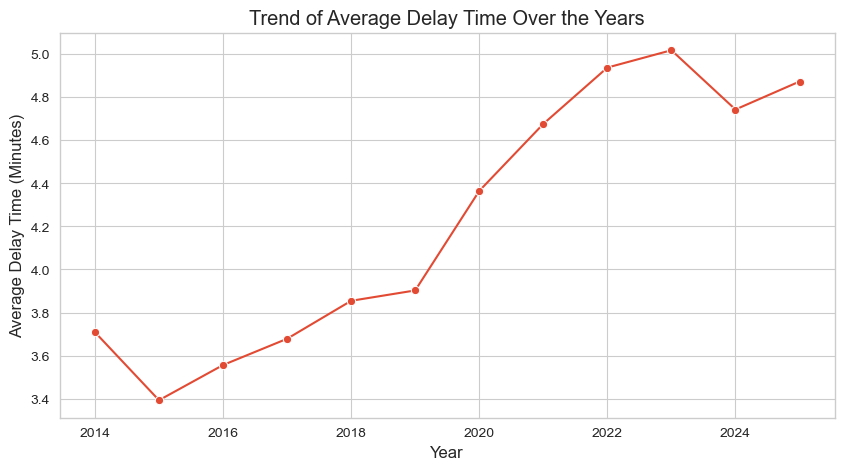

In [41]:
# 16. Plot of Trend of Average Delay Time Over the Years

df["Year"] = df["Date"].dt.year # Extracting Year from Date for trend analysis
yearly_trend = df.groupby("Year")["Min Delay"].mean() # Grouping by year and calculating the average delay time
plt.figure(figsize=(10, 5)) # Plotting of trend
sns.lineplot(x=yearly_trend.index, y=yearly_trend.values, marker="o")
plt.title("Trend of Average Delay Time Over the Years")
plt.xlabel("Year")
plt.ylabel("Average Delay Time (Minutes)")
plt.grid(True)
plt.savefig("plot16.jpg", dpi=300, bbox_inches="tight") #Saving Plot
plt.show() #Showing Plot


C:\Users\ifara\AppData\Local\Temp\ipykernel_3816\862844170.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


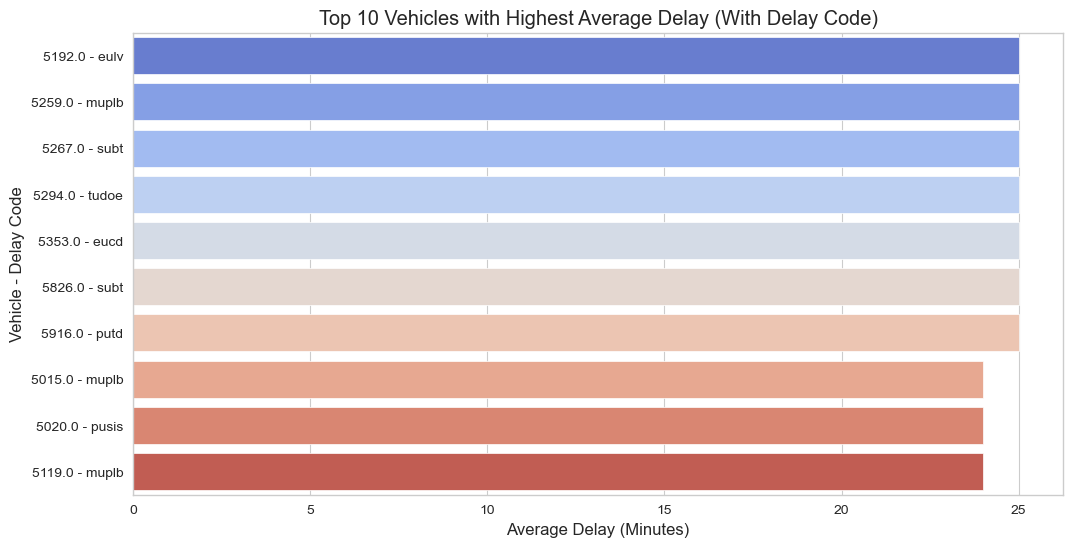

C:\Users\ifara\AppData\Local\Temp\ipykernel_3816\862844170.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


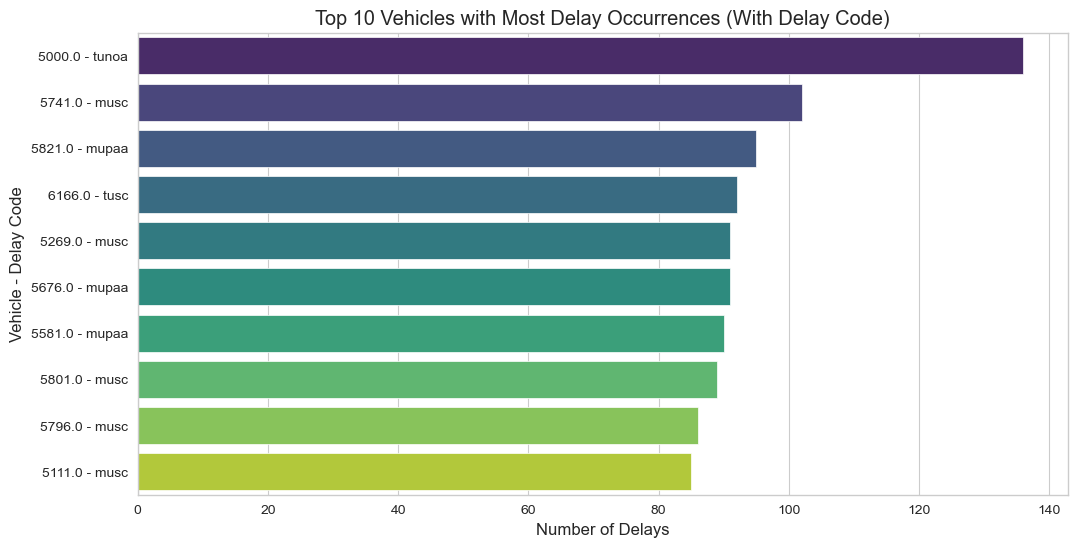

In [42]:
# 17. Top 10 Delayed Vehicles versus Code
top_delayed_vehicles = (
    df.groupby(["Vehicle", "Code"])["Min Delay"]
    .mean()
    .nlargest(10)
    .reset_index()
)
plt.figure(figsize=(12, 6))
sns.barplot(
    x=top_delayed_vehicles["Min Delay"],
    y=top_delayed_vehicles["Vehicle"].astype(str) + " - " + top_delayed_vehicles["Code"],
    palette="coolwarm",
)

plt.title("Top 10 Vehicles with Highest Average Delay (With Delay Code)")
plt.xlabel("Average Delay (Minutes)")
plt.ylabel("Vehicle - Delay Code")
plt.savefig("plot17.jpg", dpi=300, bbox_inches="tight") #Saving Plot
plt.show() #Showing Plot


# 18. Plotting the top 10 vehicles with the highest delay occurrences versus Delay Code
top_delayed_vehicle_counts = (
    df.groupby(["Vehicle", "Code"])["Min Delay"]
    .count()
    .nlargest(10)
    .reset_index()
)
plt.figure(figsize=(12, 6)) # Creating the bar chart
sns.barplot(
    x=top_delayed_vehicle_counts["Min Delay"],
    y=top_delayed_vehicle_counts["Vehicle"].astype(str) + " - " + top_delayed_vehicle_counts["Code"],
    palette="viridis",
)
plt.title("Top 10 Vehicles with Most Delay Occurrences (With Delay Code)")
plt.xlabel("Number of Delays")
plt.ylabel("Vehicle - Delay Code")
plt.savefig("plot18.jpg", dpi=300, bbox_inches="tight") #Saving Plot
plt.show() #Showing Plot


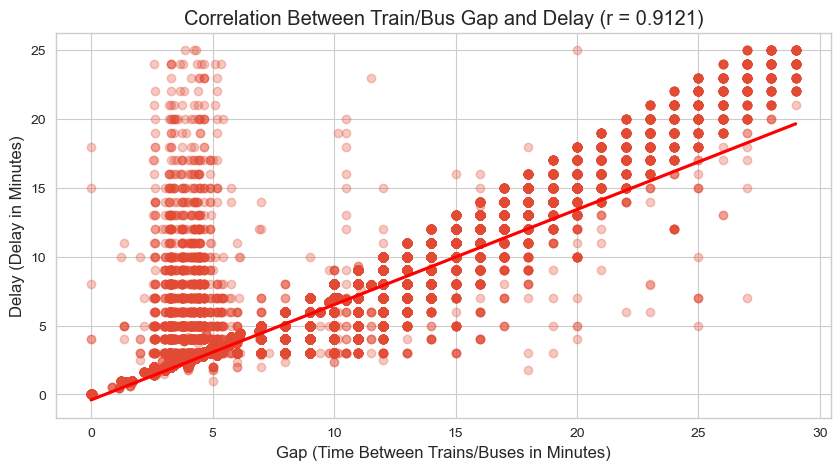

In [43]:
# 19. Plot of Correlation Between Gap and Delay

correlation_value = df["Min Gap"].corr(df["Min Delay"]) # correlation between "Min Gap" and "Min Delay"
plt.figure(figsize=(10, 5)) #scatter plot
sns.regplot(x=df["Min Gap"], y=df["Min Delay"], scatter_kws={"alpha": 0.3}, line_kws={"color": "red"})
plt.title(f"Correlation Between Train/Bus Gap and Delay (r = {correlation_value:.4f})")
plt.xlabel("Gap (Time Between Trains/Buses in Minutes)")
plt.ylabel("Delay (Delay in Minutes)")
plt.savefig("plot19.jpg", dpi=300, bbox_inches="tight") #Save Plot
plt.show() #Show Plot

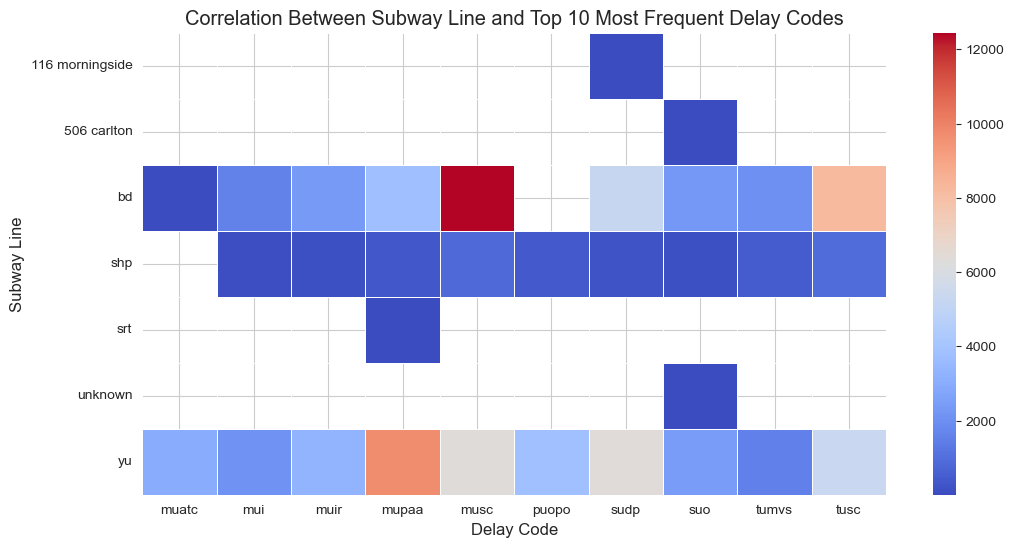

In [44]:
# 20. Plot of correlation between Line and Delay Code (delay reason - 10 most frequent codes)

top_delay_codes = df["Code"].value_counts().nlargest(10).index #top 10 most frequent delay codes
df_top_codes = df[df["Code"].isin(top_delay_codes)] # Filter dataset for only the top 10 most frequent delay codes
pivot_table = df_top_codes.pivot_table(index="Line", columns="Code", values="Min Delay", aggfunc="count") #pivot table for count of delays per Line and Delay Code
plt.figure(figsize=(12, 6)) #heatmap
sns.heatmap(pivot_table, cmap="coolwarm", linewidths=0.5, cbar=True, annot=False)
plt.title("Correlation Between Subway Line and Top 10 Most Frequent Delay Codes")
plt.xlabel("Delay Code")
plt.ylabel("Subway Line")
plt.savefig("plot20.jpg", dpi=300, bbox_inches="tight") #Save Plot
plt.show() #Show Plot

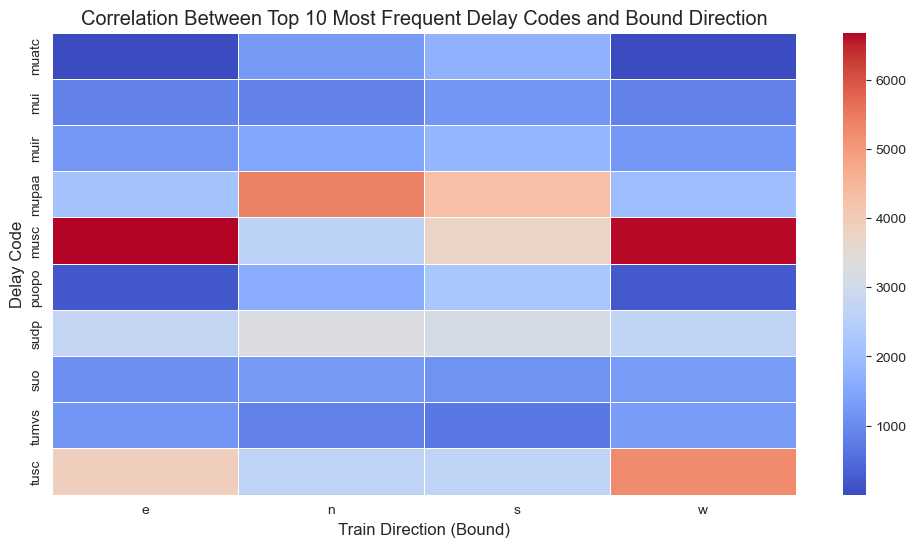

In [45]:
# 21. Plot of correlation between Delay Code (most frequent) and Bound Direction

top_delay_codes = df["Code"].value_counts().nlargest(10).index # Getting the top 10 most frequent delay codes
df_top_codes = df[df["Code"].isin(top_delay_codes)] # Filtering dataset for only the top 10 most frequent delay codes
pivot_table = df_top_codes.pivot_table(index="Code", columns="Bound", values="Min Delay", aggfunc="count")
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, cmap="coolwarm", linewidths=0.5, cbar=True, annot=False)
plt.title("Correlation Between Top 10 Most Frequent Delay Codes and Bound Direction")
plt.xlabel("Train Direction (Bound)")
plt.ylabel("Delay Code")
plt.savefig("plot21.jpg", dpi=300, bbox_inches="tight") #Saving Plot
plt.show() #Showing Plot

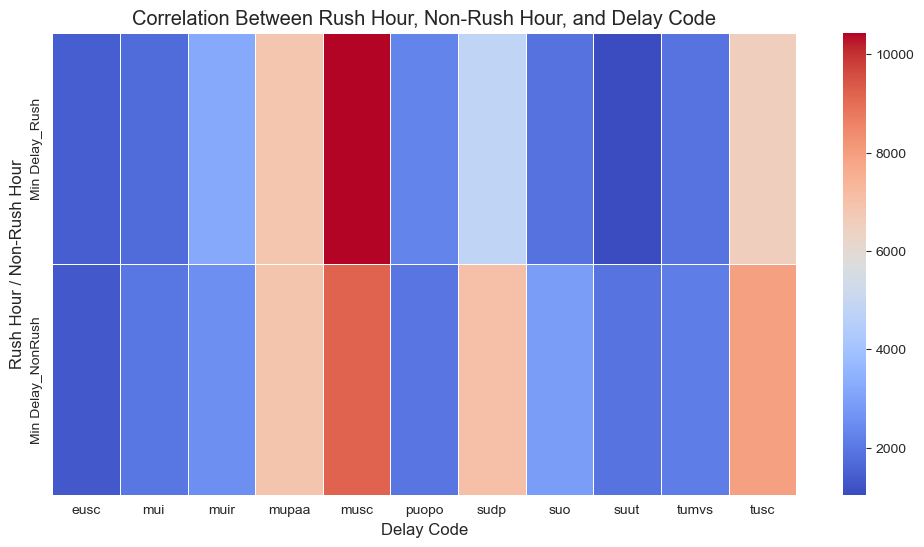

In [46]:
# 22. Plot of Correlation Between Rush Hour and Delay Code

top_delay_codes_rush = df_rush["Code"].value_counts().nlargest(10).index # top 10 most frequent delay codes in rush hour dataframe
top_delay_codes_non_rush = df_non_rush["Code"].value_counts().nlargest(10).index # top 10 most frequent delay codes in non-rush hour dataframe
top_delay_codes = list(set(top_delay_codes_rush).union(set(top_delay_codes_non_rush))) # Combining the unique top delay codes from both datasets
df_rush_top = df_rush[df_rush["Code"].isin(top_delay_codes)] # Filtering rush hour dataset for only the top delay codes
df_non_rush_top = df_non_rush[df_non_rush["Code"].isin(top_delay_codes)] # Filter non-rush hour dataset for only the top delay codes
pivot_rush = df_rush_top.pivot_table(index="Code", values="Min Delay", aggfunc="count") #pivot tables for rush hour
pivot_non_rush = df_non_rush_top.pivot_table(index="Code", values="Min Delay", aggfunc="count") #pivot tables for non-rush hour
correlation_df = pd.merge(pivot_rush, pivot_non_rush, on="Code", how="outer", suffixes=("_Rush", "_NonRush")).fillna(0) # Merging the two pivot tables
plt.figure(figsize=(12, 6))
sns.heatmap(correlation_df.T, cmap="coolwarm", linewidths=0.5, cbar=True, annot=False) # heatmap plot
plt.title("Correlation Between Rush Hour, Non-Rush Hour, and Delay Code")
plt.xlabel("Delay Code")
plt.ylabel("Rush Hour / Non-Rush Hour")
plt.savefig("plot22.jpg", dpi=300, bbox_inches="tight") #Saving Plot
plt.show() #Showing Plot

Part 1 Complete (by Faraz Shahid)

In [47]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split


In [48]:
df = pd.read_csv(url, encoding="utf-8")


In [49]:
df.dtypes

Date          object
Time          object
Day           object
Station       object
Code          object
Min Delay    float64
Min Gap      float64
Bound         object
Line          object
Vehicle      float64
dtype: object

In [50]:
df['Date'] = pd.to_datetime(df['Date'])
df['Time'] = pd.to_datetime(df['Time'])

C:\Users\ifara\AppData\Local\Temp\ipykernel_3816\2029396998.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time'])


In [51]:
df.dtypes

Date         datetime64[ns]
Time         datetime64[ns]
Day                  object
Station              object
Code                 object
Min Delay           float64
Min Gap             float64
Bound                object
Line                 object
Vehicle             float64
dtype: object

In [52]:
df['Hour'] = df['Time'].dt.hour
df['Minute'] = df['Time'].dt.minute
df['Month'] = df['Date'].dt.month

In [53]:
categorical_columns = ['Day', 'Station', 'Code', 'Bound', 'Line']

In [54]:
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

In [55]:
df.columns

Index(['Date', 'Time', 'Min Delay', 'Min Gap', 'Vehicle', 'Hour', 'Minute',
       'Month', 'Day_Monday', 'Day_Saturday',
       ...
       'Line_YU/BD', 'Line_YU/BD LINE', 'Line_YU/BD LINES', 'Line_YU/BD/SHP',
       'Line_YU/SHEP', 'Line_YUS', 'Line_YUS & BD', 'Line_YUS AND BD',
       'Line_YUS/BD', 'Line_YU\BD'],
      dtype='object', length=1641)

In [56]:
df['Vehicle'].nunique()

1457

In [57]:
le = LabelEncoder()
df['Vehicle'] = le.fit_transform(df['Vehicle'])

In [58]:
df.head()

,Date,Time,Min Delay,Min Gap,Vehicle,Hour,Minute,Month,Day_Monday,Day_Saturday,...,Line_YU/BD,Line_YU/BD LINE,Line_YU/BD LINES,Line_YU/BD/SHP,Line_YU/SHEP,Line_YUS,Line_YUS & BD,Line_YUS AND BD,Line_YUS/BD,Line_YU\BD
0,2014-01-01,2025-03-20 00:21:00,55.0,60.0,380,0,21,1,False,False,...,False,False,False,False,False,False,False,False,False,False
1,2014-01-01,2025-03-20 02:06:00,3.0,7.0,270,2,6,1,False,False,...,False,False,False,False,False,False,False,False,False,False
2,2014-01-01,2025-03-20 02:40:00,0.0,0.0,0,2,40,1,False,False,...,False,False,False,False,False,False,False,False,False,False
3,2014-01-01,2025-03-20 03:10:00,3.0,8.0,385,3,10,1,False,False,...,False,False,False,False,False,False,False,False,False,False
4,2014-01-01,2025-03-20 03:20:00,5.0,10.0,652,3,20,1,False,False,...,False,False,False,False,False,False,False,False,False,False


In [59]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'

df['Season'] = df['Month'].apply(get_season)

In [60]:
#Split the data

X = df.drop(columns=['Min Delay'])
y = df['Min Delay']



In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Part 2 Complete (by Joey Poh)

Some further data processing for part 3

In [62]:

X_train = X_train.select_dtypes(include=[np.number])
X_test = X_test.select_dtypes(include=[np.number])


In [63]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [64]:
import pandas as pd

#convert back to DataFrame (since NumPy arrays do not support dropna)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

#now drop NaN values
X_train_scaled_df = X_train_scaled_df.dropna()
X_test_scaled_df = X_test_scaled_df.dropna()

#ensure target variable remains aligned
y_train = y_train.loc[X_train_scaled_df.index]
y_test = y_test.loc[X_test_scaled_df.index]

#convert back to NumPy for training
X_train_scaled = X_train_scaled_df.to_numpy()
X_test_scaled = X_test_scaled_df.to_numpy()


In [65]:
#4.1 Baseline Model: Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#train model
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

#make predictions
y_pred_lr = lr_model.predict(X_test_scaled)

#evaluate model
mae_lr = mean_absolute_error(y_test, y_pred_lr)
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print(f"Linear Regression Performance:\n MAE: {mae_lr:.2f} | MSE: {mse_lr:.2f} | R²: {r2_lr:.2f}")


Linear Regression Performance:
 MAE: 1.26 | MSE: 10.48 | R²: 0.86


In [66]:
from sklearn.ensemble import RandomForestRegressor

#4.2 Advanced Model: Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

#make predictions
y_pred_rf = rf_model.predict(X_test_scaled)

#evaluate Model
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest Performance:\n MAE: {mae_rf:.2f} | MSE: {mse_rf:.2f} | R²: {r2_rf:.2f}")


Random Forest Performance:
 MAE: 0.39 | MSE: 8.56 | R²: 0.89


In [67]:
from sklearn.model_selection import GridSearchCV

In [68]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}


In [69]:
#import random forest
from sklearn.ensemble import RandomForestRegressor


In [70]:
from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(RandomForestRegressor(random_state=42),
                                   param_distributions=param_grid,
                                   n_iter=5,
                                   cv=3,
                                   n_jobs=-1,
                                   verbose=2,
                                   random_state=42)

random_search.fit(X_train_scaled, y_train)

#get the best model
best_rf_model = random_search.best_estimator_


Fitting 3 folds for each of 5 candidates, totalling 15 fits


In [71]:
#make predictions
y_pred_best_rf = best_rf_model.predict(X_test_scaled)

Evaluate optimized model

In [72]:
mae_best_rf = mean_absolute_error(y_test, y_pred_best_rf)

In [73]:
mse_best_rf = mean_squared_error(y_test, y_pred_best_rf)

In [74]:
r2_best_rf = r2_score(y_test, y_pred_best_rf)

In [75]:
print(f"Optimized Random Forest Performance:\n MAE: {mae_best_rf:.2f} | MSE: {mse_best_rf:.2f} | R²: {r2_best_rf:.2f}")

Optimized Random Forest Performance:
 MAE: 0.38 | MSE: 7.97 | R²: 0.89


Part 3 Complete (by Tian Olivia Qin)

Part 4

In [76]:
#compare model performance
performance_metrics = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest", "Optimized Random Forest"],
    "MAE": [mae_lr, mae_rf, mae_best_rf],
    "MSE": [mse_lr, mse_rf, mse_best_rf],
    "R²": [r2_lr, r2_rf, r2_best_rf]
})

print(performance_metrics)


                     Model       MAE        MSE        R²
0        Linear Regression  1.259023  10.480041  0.860641
1            Random Forest  0.386622   8.558926  0.886187
2  Optimized Random Forest  0.376856   7.973001  0.893978


C:\Users\ifara\AppData\Local\Temp\ipykernel_3816\1103694741.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances["Importance"], y=feature_importances["Feature"], palette="viridis")


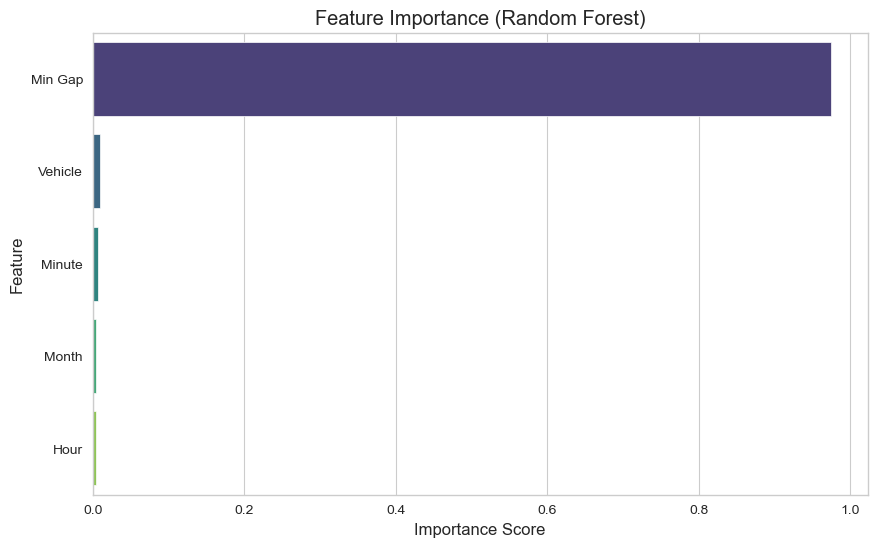

In [77]:
#feature importance analysis
import matplotlib.pyplot as plt
import seaborn as sns

feature_importances = pd.DataFrame({
    "Feature": X_train_scaled_df.columns,
    "Importance": best_rf_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

#plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances["Importance"], y=feature_importances["Feature"], palette="viridis")
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()


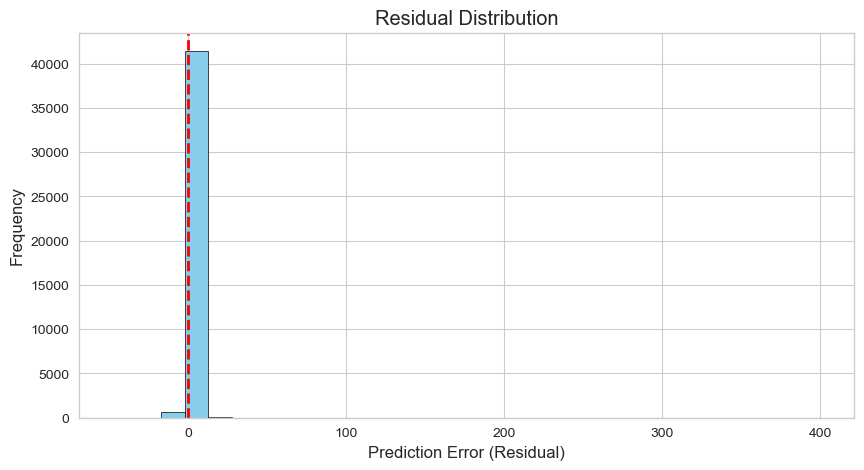

In [78]:
import matplotlib.pyplot as plt

#residual analysis
residuals = y_test - y_pred_best_rf

plt.figure(figsize=(10, 5))
plt.hist(residuals, bins=30, color="skyblue", edgecolor="black")
plt.axvline(x=0, color="red", linestyle="dashed", linewidth=2)
plt.title("Residual Distribution")
plt.xlabel("Prediction Error (Residual)")
plt.ylabel("Frequency")
plt.show()


In [79]:
#created a dtaFrame with errors
error_df = pd.DataFrame({
    "Actual Delay": y_test,
    "Predicted Delay": y_pred_best_rf,
    "Error": residuals
})

#sorted by highest errors
error_df["Absolute Error"] = abs(error_df["Error"])
error_df = error_df.sort_values(by="Absolute Error", ascending=False)

print(error_df.head(10))  #top 10 highest errors


        Actual Delay  Predicted Delay       Error  Absolute Error
76348          399.0         0.000196  398.999804      398.999804
129775         275.0         6.026329  268.973671      268.973671
23508          139.0         3.803073  135.196927      135.196927
153204         126.0         0.000412  125.999588      125.999588
132188          58.0         2.146552   55.853448       55.853448
204627          53.0         2.328624   50.671376       50.671376
24251            0.0        46.773600  -46.773600       46.773600
64212           50.0         3.383616   46.616384       46.616384
5827            45.0         3.105305   41.894695       41.894695
176784          42.0         0.396191   41.603809       41.603809


Reviewing performance review and model selection below.

Checking if models, other than Linear Regression and Random Forest, perform better.

In [80]:
#baseline comparison-XGBoost

!pip install xgboost

import xgboost as xgb

#train XGBoost model
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, random_state=42)
xgb_model.fit(X_train_scaled, y_train)

#make predictions
y_pred_xgb = xgb_model.predict(X_test_scaled)

#evaluate XGBoost model
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost Performance:\n MAE: {mae_xgb:.2f} | MSE: {mse_xgb:.2f} | R²: {r2_xgb:.2f}")


XGBoost Performance:
 MAE: 0.42 | MSE: 10.76 | R²: 0.86


In [81]:
#Random Forest + XGBoost

from sklearn.ensemble import StackingRegressor

#define base models
base_models = [
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('xgb', xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, random_state=42))
]

#stacking ensemble model
stacked_model = StackingRegressor(estimators=base_models, final_estimator=LinearRegression())

#train stacked model
stacked_model.fit(X_train_scaled, y_train)

#make predictions
y_pred_stacked = stacked_model.predict(X_test_scaled)

#evaluate stacked model
mae_stacked = mean_absolute_error(y_test, y_pred_stacked)
mse_stacked = mean_squared_error(y_test, y_pred_stacked)
r2_stacked = r2_score(y_test, y_pred_stacked)

print(f"Stacked Model Performance:\n MAE: {mae_stacked:.2f} | MSE: {mse_stacked:.2f} | R²: {r2_stacked:.2f}")


Stacked Model Performance:
 MAE: 0.41 | MSE: 9.20 | R²: 0.88


Model Evaluation:
As per the analysis done above, out of all the models, Optimized Random Forest performs best.

In [82]:
#feature importance analysis
#adding rolling averages and lag features to determine which factors impact subway delays the most

#create lag features (previous delays)
df['Prev_Delay_1'] = df['Min Delay'].shift(1)
df['Prev_Delay_2'] = df['Min Delay'].shift(2)

#create rolling average features
df['Rolling_Mean_3'] = df['Min Delay'].rolling(window=3).mean()
df['Rolling_Mean_5'] = df['Min Delay'].rolling(window=5).mean()

#fill NaN values
df = df.fillna(0)


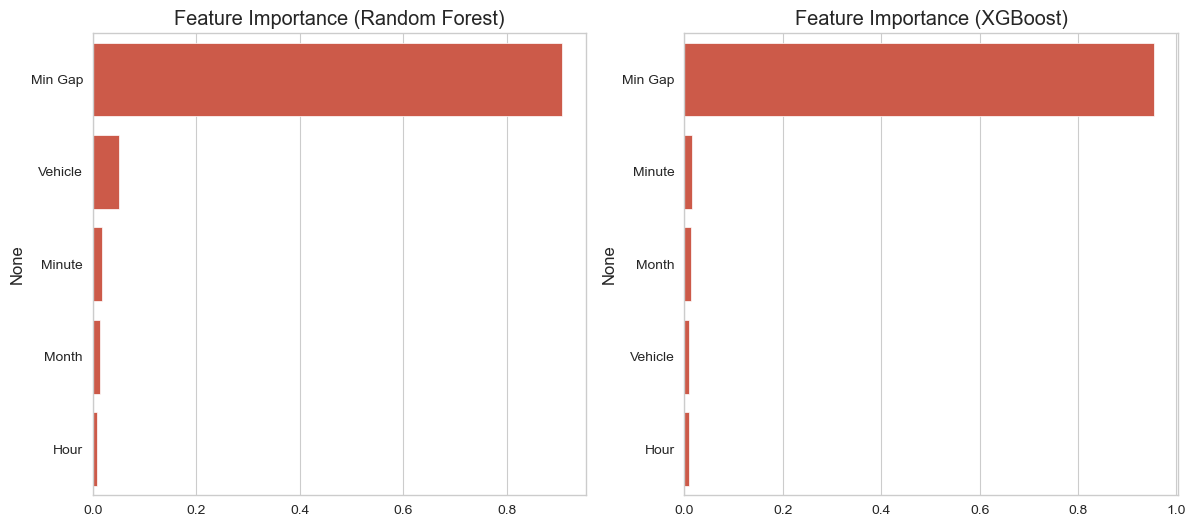

In [83]:
#re-run feature importance analysis (Random Forest vs. XGBoost)

import matplotlib.pyplot as plt
import seaborn as sns

#get feature importance from Random Forest
rf_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

#get feature importance from XGBoost
xgb_importances = pd.Series(xgb_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

#plot feature importances for comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.barplot(x=rf_importances.values[:10], y=rf_importances.index[:10], ax=axes[0])
axes[0].set_title("Feature Importance (Random Forest)")

sns.barplot(x=xgb_importances.values[:10], y=xgb_importances.index[:10], ax=axes[1])
axes[1].set_title("Feature Importance (XGBoost)")

plt.show()


While calculating the residuals, it was noticed that our model was trained on 5 features and X_test has 1652 features. Hence, we're running some additional checks below before performing the error analysis

In [84]:
print(f"Data passed to predict: {X_test.shape}")


Data passed to predict: (42383, 5)


In [85]:
missing_indices = set(y_test.index) - set(X_test.index)
print(f"Missing indices count: {len(missing_indices)}")
print(f"Missing indices: {missing_indices}")


Missing indices count: 0
Missing indices: set()


In [86]:
for col in X_train.columns:
    if col in X_test.columns:
        unseen = set(X_test[col]) - set(X_train[col])
        if unseen:
            print(f"Unseen values in column {col}: {unseen}")


Unseen values in column Min Gap: {nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 132.0, nan, nan, nan, nan, 137.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 191.0, nan, 193.0, 194.0, nan, nan, nan, nan, nan, 212.0, 224.0, 226.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 254.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 290.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, n

In [87]:
print(f"Features used in training: {X_train_scaled.shape[1]}")


Features used in training: 5


In [88]:
print(f"Model was trained on {best_rf_model.n_features_in_} features")
print(f"X_test has {X_test.shape[1]} features")


Model was trained on 5 features
X_test has 5 features


In [89]:
print("Expected number of features:", best_rf_model.n_features_in_)


Expected number of features: 5


In [90]:
if isinstance(X_train, pd.DataFrame):
    trained_feature_names = list(X_train.columns[: best_rf_model.n_features_in_])
    print("Recovered feature names:", trained_feature_names)


Recovered feature names: ['Min Gap', 'Vehicle', 'Hour', 'Minute', 'Month']


In [91]:
X_test_aligned = X_test[trained_feature_names]
y_pred_best_rf = best_rf_model.predict(X_test_aligned)
print(f"New prediction shape: {y_pred_best_rf.shape}")


New prediction shape: (42383,)


c:\Users\ifara\miniconda3\envs\faraz_shahid\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


In [92]:
#error analysis
#applying log transformation to target variable

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Apply log transformation to delay times, ensuring no zero values
EPSILON = 1e-5  # Small constant to avoid log(0)
df['Log_Min_Delay'] = np.log1p(df['Min Delay'] + EPSILON)

# Prepare features (X) and target (y)
X = df.drop(columns=['Min Delay', 'Log_Min_Delay'])
y = df['Log_Min_Delay']

# Convert datetime columns into numerical features
for col in X.select_dtypes(include=['datetime64']).columns:
    X[f'{col}_Year'] = X[col].dt.year
    X[f'{col}_Month'] = X[col].dt.month
    X[f'{col}_Day'] = X[col].dt.day
    X[f'{col}_Hour'] = X[col].dt.hour
    X.drop(columns=[col], inplace=True)

# Identify categorical columns and apply Label Encoding
categorical_cols = X.select_dtypes(include=['object']).columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])  # Convert categories to numbers
    label_encoders[col] = le  # Store encoders for inverse transform if needed

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ensure all columns are numerical
print("Data types after encoding:")
print(X_train.dtypes)

# Apply scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
y_pred_best_rf = rf_model.predict(X_test_scaled)


Data types after encoding:
Min Gap       float64
Vehicle         int64
Hour            int32
Minute          int32
Month           int32
               ...   
Date_Hour       int32
Time_Year       int32
Time_Month      int32
Time_Day        int32
Time_Hour       int32
Length: 1651, dtype: object


Part 4 Complete (by Peeu Banerjee)

Plotting actual vs predicted delays...


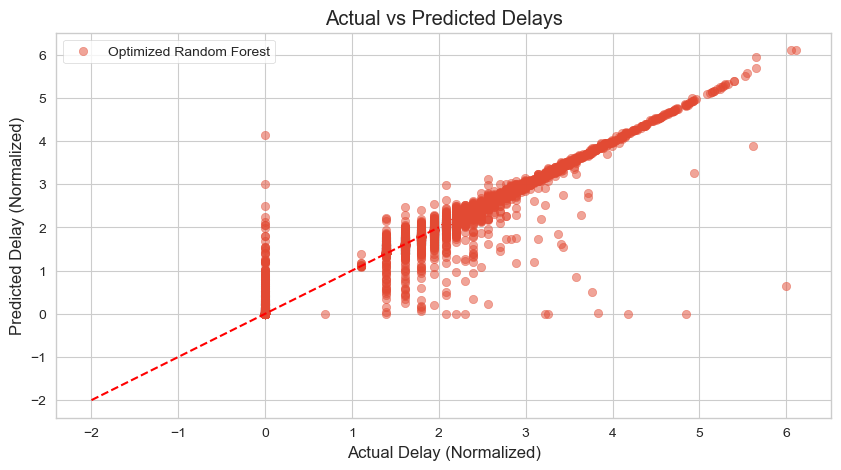

In [93]:
# Compare actual delay times with predicted delay times
import matplotlib.pyplot as plt

print("Plotting actual vs predicted delays...")
plt.figure(figsize=(10, 5))

# Directly use y_pred_best_rf and y_test for the scatter plot
plt.scatter(y_test, y_pred_best_rf, alpha=0.5, label="Optimized Random Forest")

plt.plot([-2, 2], [-2, 2], color='red', linestyle='dashed')  # Reference line for perfect prediction
plt.xlabel("Actual Delay (Normalized)")
plt.ylabel("Predicted Delay (Normalized)")
plt.title("Actual vs Predicted Delays")
plt.legend()
plt.show()

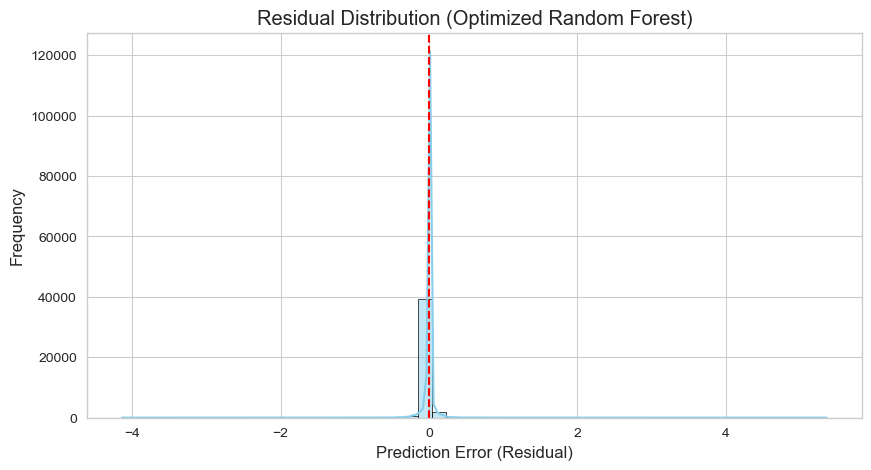

In [94]:
#compute residuals

residuals = y_test - y_pred_best_rf

# Plot residual distribution
plt.figure(figsize=(10, 5))
sns.histplot(residuals, bins=50, kde=True, color="skyblue", edgecolor="black")
plt.axvline(x=0, color='red', linestyle='dashed')
plt.title("Residual Distribution (Optimized Random Forest)")
plt.xlabel("Prediction Error (Residual)")
plt.ylabel("Frequency")
plt.show()


In [95]:
# Analyzing high error cases

error_df = pd.DataFrame({
    'Actual Delay': np.expm1(y_test) - EPSILON,  # Convert back from log scale
    'Predicted Delay': np.expm1(y_pred_best_rf) - EPSILON,
    'Error': (np.expm1(y_test) - np.expm1(y_pred_best_rf)),
    'Absolute Error': abs(np.expm1(y_test) - np.expm1(y_pred_best_rf))
})

# Sort by highest error cases
high_error_cases = error_df.sort_values(by='Absolute Error', ascending=False).head(10)

# Display results
print("Top High-Error Cases:")
print(high_error_cases)

# Performance Metrics
mae = mean_absolute_error(y_test, y_pred_best_rf)
mse = mean_squared_error(y_test, y_pred_best_rf)
rmse = np.sqrt(mse)
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")


Top High-Error Cases:
        Actual Delay  Predicted Delay       Error  Absolute Error
76348   3.990000e+02     8.881803e-01  398.111820      398.111820
129775  2.750000e+02     4.729301e+01  227.706986      227.706986
153204  1.260000e+02    -2.661378e-18  126.000000      126.000000
23508   1.390000e+02     2.478524e+01  114.214762      114.214762
93895   2.840000e+02     3.772483e+02  -93.248322       93.248322
210657  6.400000e+01     1.151965e-19   64.000000       64.000000
23114  -1.694066e-21     6.154453e+01  -61.544529       61.544529
5827    4.500000e+01     2.426891e-02   44.975731       44.975731
176784  4.200000e+01     6.625208e-01   41.337479       41.337479
170353  3.500000e+01     1.315053e+00   33.684947       33.684947
Mean Absolute Error: 0.0205
Root Mean Squared Error: 0.1083
